Data Collection with CCXT

In [64]:
import ccxt
import pandas as pd

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

# Initialize the exchange
exchange = ccxt.binance()

symbol = 'BTC/USDT'
timeframe = '1d'
since = exchange.parse8601('2021-01-01T00:00:00Z')
now = exchange.milliseconds()

all_candles = []

while since < now:
    candles = exchange.fetch_ohlcv(symbol, timeframe, since)
    if len(candles) == 0:
        break
    since = candles[-1][0] + 1  # start the next fetch from the end of the last one
    all_candles += candles

# Convert to DataFrame
df = pd.DataFrame(all_candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')

# Create a copy with the closing price for forecasting
data = df[['date', 'close', 'volume', 'high', 'low']].copy()
data.rename(columns={'date': 'ds', 'close': 'y', 'volume': 'volume', 'high': 'high', 'low': 'low'}, inplace=True)

print(data.head())
# print(data.describe())


          ds         y         volume      high       low
0 2021-01-01  29331.69   54182.925011  29600.00  28624.57
1 2021-01-02  32178.33  129993.873362  33300.00  28946.53
2 2021-01-03  33000.05  120957.566750  34778.11  31962.99
3 2021-01-04  31988.71  140899.885690  33600.00  28130.00
4 2021-01-05  33949.53  116049.997038  34360.00  29900.00
                                  ds             y         volume  \
count                           1020   1020.000000    1020.000000   
mean   2022-05-25 12:00:00.000000256  34557.626873  110479.746822   
min              2021-01-01 00:00:00  15781.290000    8971.480680   
25%              2021-09-12 18:00:00  23765.887500   40194.445645   
50%              2022-05-25 12:00:00  30449.965000   64454.330440   
75%              2023-02-04 06:00:00  43924.860000  139985.962967   
max              2023-10-17 00:00:00  67525.830000  760705.362783   
std                              NaN  12908.485718  111775.187001   

               high           

Hyperparameter tuning for Prophet model using Grid Search

In [65]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import itertools
import numpy as np

# Define parameter grid
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [True, False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Placeholder for best params and RMSE
best_params = {}
lowest_rmse = float('inf')

# Function to train and evaluate a model
def train_evaluate_model(params, data):
    model = Prophet(**params)
    model.fit(data)
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    rmse = np.sqrt(mean_squared_error(data['y'], forecast[:len(data)]['yhat']))
    return rmse

# Grid search loop
for params in all_params:
    rmse = train_evaluate_model(params, data)
    if rmse < lowest_rmse:
        best_params = params
        lowest_rmse = rmse

print(f"Best parameters: {best_params}")
print(f"Lowest RMSE: {lowest_rmse}")

06:22:15 - cmdstanpy - INFO - Chain [1] start processing
06:22:15 - cmdstanpy - INFO - Chain [1] done processing
06:22:15 - cmdstanpy - INFO - Chain [1] start processing
06:22:15 - cmdstanpy - INFO - Chain [1] done processing
06:22:16 - cmdstanpy - INFO - Chain [1] start processing
06:22:16 - cmdstanpy - INFO - Chain [1] done processing
06:22:16 - cmdstanpy - INFO - Chain [1] start processing
06:22:16 - cmdstanpy - INFO - Chain [1] done processing
06:22:17 - cmdstanpy - INFO - Chain [1] start processing
06:22:17 - cmdstanpy - INFO - Chain [1] done processing
06:22:17 - cmdstanpy - INFO - Chain [1] start processing
06:22:17 - cmdstanpy - INFO - Chain [1] done processing
06:22:17 - cmdstanpy - INFO - Chain [1] start processing
06:22:17 - cmdstanpy - INFO - Chain [1] done processing
06:22:18 - cmdstanpy - INFO - Chain [1] start processing
06:22:18 - cmdstanpy - INFO - Chain [1] done processing
06:22:18 - cmdstanpy - INFO - Chain [1] start processing
06:22:18 - cmdstanpy - INFO - Chain [1]

Best parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True}
Lowest RMSE: 2003.7079475729859


Plot the historical Bitcoin prices

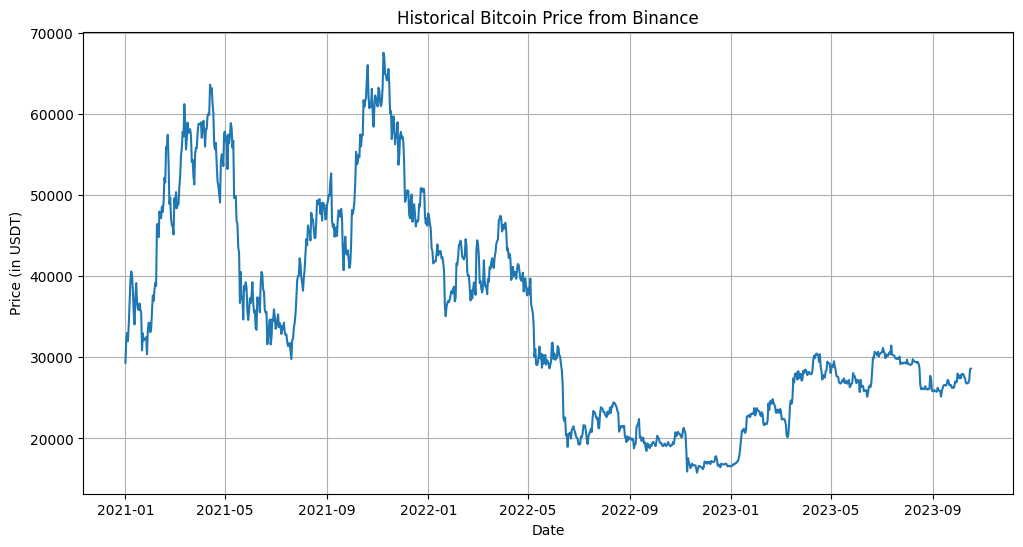

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['ds'], data['y'])
plt.title('Historical Bitcoin Price from Binance')
plt.xlabel('Date')
plt.ylabel('Price (in USDT)')
plt.grid(True)
plt.show()

Add additional regressors/features & Clean Data

In [67]:
import talib

# Adding short term moving averages
data['ma5'] = data['y'].rolling(window=5).mean()
data['ma10'] = data['y'].rolling(window=10).mean()
data['rsi'] = talib.RSI(data['y'].values, timeperiod=16)
data['obv'] = talib.OBV(data['y'].values, data['volume'].values)
data['macd'], data['signal'], _ = talib.MACD(data['y'].values, fastperiod=12, slowperiod=26, signalperiod=9)

# Stochastic Oscillator
data['k'], data['d'] = talib.STOCH(data['high'].values, data['low'].values, data['y'].values, fastk_period=14, slowk_period=3, slowd_period=3)

# ATR (Average True Range)
data['atr'] = talib.ATR(data['high'].values, data['low'].values, data['y'].values, timeperiod=14)

# Bollinger Bands
data['upper'], data['middle'], data['lower'] = talib.BBANDS(data['y'].values, timeperiod=20)

# Remove NaN rows created due to rolling operations and indicators
data.dropna(inplace=True)

Fit and Train the Prophet model with features/regressors

In [68]:
from prophet import Prophet

# Initialize the Prophet model
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)

# Add regressors for the model
model.add_regressor('rsi')
model.add_regressor('obv')
model.add_regressor('ma5')
model.add_regressor('ma10')
model.add_regressor('macd')
model.add_regressor('signal')
model.add_regressor('k')
model.add_regressor('d')
model.add_regressor('atr')
model.add_regressor('upper')
model.add_regressor('middle')
model.add_regressor('lower')

# Train the model with the data
model.fit(data)

06:23:01 - cmdstanpy - INFO - Chain [1] start processing
06:23:02 - cmdstanpy - INFO - Chain [1] done processing


Create future date data for which we want to predict the Bitcoin prices and then generate forecasts. Also demonstrate Forecasting with the Regressor/Feature

In [69]:

# Initialize an empty dictionary to hold the forecasts for each indicator
forecasts = {}

# List of all TA indicators
indicators = ['ma5', 'ma10', 'rsi', 'obv', 'macd', 'signal', 'k', 'd', 'atr', 'upper', 'middle', 'lower']

# Loop through each indicator to forecast it
for indicator in indicators:
    # Prepare DataFrame for Prophet
    ind_df = data[['ds', indicator]].dropna()
    ind_df.rename(columns={indicator: 'y'}, inplace=True)
    
    # Initialize and fit Prophet model
    ind_model = Prophet()
    ind_model.fit(ind_df)
    
    # Make future DataFrame and forecast
    ind_future = ind_model.make_future_dataframe(periods=365)
    ind_forecast = ind_model.predict(ind_future)
    
    # Store the forecast in the dictionary
    forecasts[indicator] = ind_forecast['yhat']

# Prepare the main future DataFrame
main_future = model.make_future_dataframe(periods=365)

# Add the forecasted values of each indicator to the main future DataFrame
for indicator in indicators:
    main_future[indicator] = forecasts[indicator]

# Now you can proceed with the main Prophet model's prediction
main_forecast = model.predict(main_future)

06:23:02 - cmdstanpy - INFO - Chain [1] start processing
06:23:03 - cmdstanpy - INFO - Chain [1] done processing
06:23:03 - cmdstanpy - INFO - Chain [1] start processing
06:23:04 - cmdstanpy - INFO - Chain [1] done processing
06:23:04 - cmdstanpy - INFO - Chain [1] start processing
06:23:04 - cmdstanpy - INFO - Chain [1] done processing
06:23:04 - cmdstanpy - INFO - Chain [1] start processing
06:23:04 - cmdstanpy - INFO - Chain [1] done processing
06:23:05 - cmdstanpy - INFO - Chain [1] start processing
06:23:05 - cmdstanpy - INFO - Chain [1] done processing
06:23:05 - cmdstanpy - INFO - Chain [1] start processing
06:23:05 - cmdstanpy - INFO - Chain [1] done processing
06:23:06 - cmdstanpy - INFO - Chain [1] start processing
06:23:06 - cmdstanpy - INFO - Chain [1] done processing
06:23:06 - cmdstanpy - INFO - Chain [1] start processing
06:23:06 - cmdstanpy - INFO - Chain [1] done processing
06:23:06 - cmdstanpy - INFO - Chain [1] start processing
06:23:07 - cmdstanpy - INFO - Chain [1]

Predict the price for the next day

In [70]:
# Predict Bitcoin price for the next day
future_day = model.make_future_dataframe(periods=1, freq='D', include_history=False)

# Use the first forecasted value for each TA indicator for the next day
for indicator in indicators:
    next_day_value = forecasts[indicator].iloc[0]
    future_day[indicator] = next_day_value

# Generate the one-day-ahead forecast
forecast_day = model.predict(future_day)
next_day_price = forecast_day['yhat'].values[0]
print(f"Predicted Bitcoin price for the next day: ${next_day_price:.2f}")

Predicted Bitcoin price for the next day: $37515.91


Rolling Window Back-Testing

In [71]:
# Define window sizes
training_window_size = 80
testing_window_size = 10

def train_and_forecast(train_data, testing_window_size):
    # Initialize and configure the Prophet model with best parameters
    model = Prophet(**best_params)
    
    # Add the regressors
    for indicator in indicators:
        model.add_regressor(indicator)
    
    model.fit(train_data)
    
    future = model.make_future_dataframe(periods=testing_window_size)
    # Ensure the future dataframe has the regressors for the testing window
    for indicator in indicators:
        future[indicator] = pd.concat([train_data[indicator], test_data[indicator]], ignore_index=True)
    
    forecast = model.predict(future)
    
    return forecast.tail(testing_window_size)

# Initialize the starting indices for the rolling window
start_idx = 0
end_idx = training_window_size + testing_window_size

forecasts = []
actuals = []

# Roll the window through the dataset
while end_idx <= len(data):
    train_data = data.iloc[start_idx:end_idx-testing_window_size]
    test_data = data.iloc[end_idx-testing_window_size:end_idx]
    
    # # Print the head of train_data and test_data
    # print("Train Data:")
    # print(train_data.head())
    # print("\nTest Data:")
    # print(test_data.head())
    # print("---------------------------------------------------")
    
    forecast = train_and_forecast(train_data, testing_window_size)
    
    forecasts.append(forecast)
    actuals.append(test_data)
    
    start_idx += testing_window_size
    end_idx += testing_window_size

06:23:09 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
           ds         y        volume      high       low        ma5  \
33 2021-02-03  37618.87  80784.333663  37662.63  35362.38  34793.468   
34 2021-02-04  36936.66  92080.735898  38708.27  36161.95  35328.224   
35 2021-02-05  38290.24  66681.334275  38310.12  36570.00  36367.676   
36 2021-02-06  39186.94  98757.311183  40955.51  38215.94  37499.790   
37 2021-02-07  38795.69  84363.679763  39700.00  37351.00  38165.680   

         ma10        rsi            obv        macd      signal          k  \
33  33667.252  61.904979  429345.332454 -213.650251 -802.099094  69.068675   
34  34135.498  60.015309  337264.596556   -1.046606 -641.888596  80.311699   
35  34717.745  62.441701  403945.930831  273.513020 -458.808273  89.394353   
36  35599.824  63.985998  502703.242014  557.038505 -255.638917  87.505049   
37  36142.907  62.784527  418339.562251  741.615013  -56.188131  87.349227   

            d          atr         upper      middle         lower  
33  57.299704  34

06:23:13 - cmdstanpy - INFO - Chain [1] done processing
06:23:13 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
           ds         y        volume      high       low        ma5  \
43 2021-02-13  47153.69  63768.097399  48150.00  46202.53  46727.760   
44 2021-02-14  48577.79  73735.475533  49707.43  47014.17  47159.234   
45 2021-02-15  47911.10  79398.156784  49010.92  45570.79  47779.938   
46 2021-02-16  49133.45  88813.266298  50689.18  47003.62  48012.726   
47 2021-02-17  52119.71  85743.637818  52618.74  48947.00  48979.148   

         ma10        rsi            obv         macd       signal          k  \
43  43322.320  69.994569  515205.727035  3232.042628  1985.053932  91.590719   
44  44486.433  71.742859  588941.202568  3438.723988  2275.787943  90.838643   
45  45448.519  69.714482  509543.045784  3508.282843  2522.286923  90.529395   
46  46443.170  71.301319  598356.312082  3620.309491  2741.891437  90.778016   
47  47775.572  74.749068  684099.949900  3905.042740  2974.521697  91.929888   

            d          atr         upper      middle         lower  
43  9

06:23:19 - cmdstanpy - INFO - Chain [1] done processing
06:23:19 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
           ds         y         volume      high       low        ma5  \
53 2021-02-23  48891.00  169375.025051  54183.59  44892.56  54426.886   
54 2021-02-24  49676.20   91881.209252  51374.99  46988.69  53180.926   
55 2021-02-25  47073.73   83310.673121  52041.73  46674.34  51427.434   
56 2021-02-26  46276.87  109423.200663  48424.11  44106.78  49201.094   
57 2021-02-27  46106.43   66060.834292  48394.00  45000.00  47604.846   

         ma10        rsi            obv         macd       signal          k  \
53  52142.908  57.107190  376825.724168  4325.674701  4173.810794  67.169667   
54  52252.749  58.257569  468706.933420  3906.285082  4120.305651  48.572881   
55  52169.012  53.212107  385396.260299  3325.582957  3961.361113  30.361624   
56  51883.354  51.748346  275973.059636  2769.151345  3722.919159  23.670119   
57  51282.026  51.425602  209912.225344  2288.047017  3435.944731  15.158016   

            d          atr         upper      middle         lower  

06:23:22 - cmdstanpy - INFO - Chain [1] done processing
06:23:22 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
           ds         y        volume      high       low        ma5  \
63 2021-03-05  48751.71  78192.496372  49448.93  46300.00  49100.570   
64 2021-03-06  48882.20  44399.234242  49200.00  47070.00  48959.604   
65 2021-03-07  50971.75  55235.028032  51450.03  48882.20  49465.824   
66 2021-03-08  52375.17  66987.359664  52402.78  49274.67  49870.984   
67 2021-03-09  54884.50  71656.737076  54895.00  51789.41  51173.066   

         ma10        rsi            obv         macd       signal          k  \
63  47977.174  54.580048  224300.599058  1369.575771  2050.999013  40.112488   
64  47897.774  54.808390  268699.833300  1276.465676  1896.092345  36.927032   
65  48287.576  58.382129  323934.861332  1355.657304  1788.005337  43.574204   
66  48897.406  60.613521  390922.220996  1514.206672  1733.245604  59.029574   
67  49775.213  64.267440  462578.958072  1821.344819  1750.865447  79.562306   

            d          atr         upper      middle         lower  
63  4

06:23:24 - cmdstanpy - INFO - Chain [1] done processing
06:23:25 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
           ds         y         volume      high       low        ma5  \
73 2021-03-15  55605.20  102771.427298  60633.43  54600.00  58151.356   
74 2021-03-16  56900.75   77986.694355  56938.29  53271.34  57976.874   
75 2021-03-17  58912.97   70421.620841  58974.73  54123.69  58315.124   
76 2021-03-18  57648.16   66580.406675  60129.97  57023.00  57607.078   
77 2021-03-19  58030.01   52392.652961  59468.00  56270.74  57419.418   

         ma10        rsi            obv         macd       signal          k  \
73  55372.199  58.372508  483710.215125  3087.887930  2621.790403  79.787325   
74  56174.054  60.209452  561696.909480  3002.870382  2698.006399  70.346486   
75  56968.176  62.920282  632118.530321  3062.559422  2770.917003  69.735203   
76  57495.475  60.171794  565538.123646  2973.526853  2811.438973  74.116229   
77  57810.026  60.724283  617930.776607  2900.346613  2829.220501  76.111598   

            d          atr         upper      middle         lower  

06:23:28 - cmdstanpy - INFO - Chain [1] done processing
06:23:28 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
           ds         y        volume      high       low        ma5  \
83 2021-03-25  51293.78  87400.534538  53287.00  50427.56  53874.626   
84 2021-03-26  55025.59  63813.774692  55073.46  51214.60  53409.432   
85 2021-03-27  55817.14  50105.475055  56700.36  53950.00  53756.210   
86 2021-03-28  55777.63  39050.387511  56559.75  54691.84  54043.558   
87 2021-03-29  57635.47  67857.937398  58405.82  54800.01  55109.922   

         ma10        rsi            obv         macd       signal          k  \
83  55896.730  46.213549  440112.987808  1024.956148  2058.374391   9.566622   
84  55709.214  53.560624  503926.762500   962.822902  1839.264093  17.937934   
85  55399.631  54.952809  554032.237555   966.314258  1664.674126  31.856696   
86  55212.578  54.865237  514981.850044   954.885728  1522.716447  46.801369   
87  55173.124  58.205812  582839.787442  1083.253623  1434.823882  58.139495   

            d          atr         upper      middle         lower  
83  1

06:23:31 - cmdstanpy - INFO - Chain [1] done processing
06:23:32 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
           ds         y        volume      high       low        ma5  \
93 2021-04-04  58202.01  41314.081973  58492.85  56388.00  58332.990   
94 2021-04-05  59129.99  54258.015790  59272.00  56777.77  58410.878   
95 2021-04-06  57991.15  54201.000727  59495.24  57413.02  58265.020   
96 2021-04-07  55953.45  71228.405659  58655.00  55473.00  57665.708   
97 2021-04-08  58077.52  44283.147019  58153.31  55700.00  57870.824   

         ma10        rsi            obv         macd       signal          k  \
93  57466.735  57.506744  570857.719319  1391.373118  1421.098899  78.183408   
94  57877.175  59.419580  625115.735109  1435.984037  1424.075927  78.797312   
95  58094.576  56.113036  570914.734382  1363.723486  1412.005439  82.000913   
96  58112.158  50.725646  499686.328723  1129.016518  1355.407655  74.331180   
97  58156.363  55.478374  543969.475742  1101.704490  1304.667022  70.107124   

            d          atr         upper      middle         lower  
93  8

06:23:36 - cmdstanpy - INFO - Chain [1] done processing
06:23:36 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y         volume      high       low        ma5  \
103 2021-04-14  62959.53   82616.343993  64854.00  61301.00  61233.218   
104 2021-04-15  63159.98   51649.700340  63800.00  62020.00  61911.388   
105 2021-04-16  61334.80   91764.139884  63520.61  60000.00  62177.862   
106 2021-04-17  60006.66   58912.256128  62506.05  59580.91  62207.194   
107 2021-04-18  56150.01  124882.131824  60499.00  50931.30  60722.196   

          ma10        rsi            obv         macd       signal          k  \
103  59546.074  64.213883  639721.807797  1771.227082  1409.652660  83.384250   
104  59949.073  64.580262  691371.508137  1904.987240  1508.719576  86.435215   
105  60283.438  58.739437  599607.368253  1842.477423  1575.471146  74.744377   
106  60688.759  54.886377  540695.112125  1666.557112  1593.688339  64.251999   
107  60496.008  45.617935  415812.980301  1202.082713  1515.367214  49.432483   

             d          atr         upper      middle   

06:23:40 - cmdstanpy - INFO - Chain [1] done processing
06:23:40 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
113 2021-04-24  50047.84  55361.512573  51166.22  48657.14  52615.314   
114 2021-04-25  49066.77  58255.645004  50567.91  46930.00  51143.668   
115 2021-04-26  54001.39  86310.802124  54356.62  48753.44  51186.420   
116 2021-04-27  55011.97  54064.034675  55460.00  53222.00  51850.622   
117 2021-04-28  54846.22  55130.459015  56428.00  53813.16  52594.838   

          ma10        rsi            obv         macd      signal          k  \
113  55936.116  34.749999   51094.738647 -1281.600463   49.184471  14.622665   
114  54526.795  33.179971   -7160.906357 -1672.782998 -295.209023  15.830738   
115  53793.454  46.217038   79149.895767 -1566.557086 -549.478635  22.018309   
116  53293.985  48.415593  133213.930442 -1384.863086 -716.555526  32.154523   
117  53163.606  48.071802   78083.471427 -1239.950544 -821.234529  43.822376   

             d          atr         upper     middle         lower  

06:23:43 - cmdstanpy - INFO - Chain [1] done processing
06:23:43 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
123 2021-05-04  53200.01  85324.625903  57200.00  53046.69  56488.450   
124 2021-05-05  57436.11  77263.923439  58069.82  52900.00  56436.818   
125 2021-05-06  56393.68  70181.671908  58360.00  55200.00  56155.480   
126 2021-05-07  57314.75  74542.747829  58650.00  55241.63  56302.788   
127 2021-05-08  58862.05  69709.906028  59500.00  56900.00  56641.320   

          ma10        rsi            obv        macd      signal          k  \
123  54892.360  44.641374   72289.140373 -420.575774 -594.530821  73.561431   
124  55729.294  52.928437  149553.063812 -221.824068 -519.989470  74.722772   
125  55968.523  50.927306   79371.391904 -146.735819 -445.338740  72.577219   
126  56198.801  52.615781  153914.139733  -12.758121 -358.822616  83.958266   
127  56600.384  55.367574  223624.045761  215.786891 -243.900715  86.540800   

             d          atr         upper      middle         lower  
123 

06:23:47 - cmdstanpy - INFO - Chain [1] done processing
06:23:48 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y         volume      high       low        ma5  \
133 2021-05-14  49841.45   80082.204306  51483.00  48799.75  52325.980   
134 2021-05-15  46762.99   89437.449359  50700.00  46555.00  50515.350   
135 2021-05-16  46431.50  114269.812775  49795.89  43825.39  48467.646   
136 2021-05-17  43538.04  166657.172736  46686.00  42001.00  47248.990   
137 2021-05-18  42849.78  116979.860784  45799.29  42250.02  45884.752   

          ma10        rsi            obv         macd       signal          k  \
133  54987.733  39.719768  256132.533742 -1104.889974  -386.850953  21.703069   
134  53920.421  35.484205  166695.084383 -1591.501595  -627.781082  20.433111   
135  52924.203  35.054848   52425.271608 -1981.056893  -898.436244  16.911093   
136  51546.532  31.505524 -114231.901128 -2494.505210 -1217.650037  10.353893   
137  49945.305  30.716425 -231211.761912 -2923.256055 -1558.771241  10.086784   

             d          atr         upper      middle   

06:23:52 - cmdstanpy - INFO - Chain [1] done processing
06:23:52 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y         volume      high       low        ma5  \
143 2021-05-24  38796.29  161630.893971  39920.00  34031.00  37735.984   
144 2021-05-25  38324.72  111996.228404  39791.77  36419.62  37295.600   
145 2021-05-26  39241.91  104780.773396  40841.00  37800.44  37693.580   
146 2021-05-27  38529.98   86547.158794  40411.14  37134.27  37909.630   
147 2021-05-28  35663.49  135377.629720  38877.83  34684.00  38111.278   

          ma10        rsi            obv         macd       signal          k  \
143  40495.232  36.425837 -513605.205341 -4984.388067 -3841.080840  24.149714   
144  39651.405  35.919929 -625601.433745 -4895.366616 -4051.937995  25.642317   
145  38932.446  37.714621 -520820.660349 -4696.666657 -4180.883728  34.722029   
146  38431.640  36.859893 -607367.819143 -4544.258922 -4253.558766  37.485499   
147  37713.011  33.590437 -742745.448863 -4601.730594 -4323.193132  36.695073   

             d          atr         upper      middle   

06:23:55 - cmdstanpy - INFO - Chain [1] done processing
06:23:55 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
153 2021-06-03  39246.79  75889.106011  39476.00  37170.00  37280.728   
154 2021-06-04  36829.00  91317.799245  39289.07  35555.15  37518.274   
155 2021-06-05  35513.20  70459.621490  37925.00  34800.00  37170.152   
156 2021-06-06  35796.31  47650.206637  36480.00  35222.00  36990.796   
157 2021-06-07  33552.79  77574.952573  36900.00  33300.00  36187.618   

          ma10        rsi            obv         macd       signal          k  \
153  37276.889  43.114805 -625470.604560 -3511.730592 -4123.899346  59.859773   
154  37127.317  39.458050 -716788.403805 -3359.872219 -3971.093921  63.025792   
155  36754.446  37.606512 -787248.025295 -3307.569822 -3838.389101  59.126089   
156  36481.079  38.271292 -739597.818658 -3206.314783 -3711.974237  45.468371   
157  36270.009  35.109275 -817172.771231 -3269.414969 -3623.462384  26.996888   

             d          atr         upper      middle         

06:23:58 - cmdstanpy - INFO - Chain [1] done processing
06:23:58 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y         volume      high       low        ma5  \
163 2021-06-13  39020.57   86921.025555  39380.00  34757.00  37192.486   
164 2021-06-14  40516.29  108522.391949  41064.05  38730.00  37818.134   
165 2021-06-15  40144.04   80679.622838  41330.00  39506.40  38511.798   
166 2021-06-16  38349.01   87771.976937  40527.14  38116.01  38715.204   
167 2021-06-17  38092.97   79541.307119  39559.88  37365.00  39224.576   

          ma10        rsi            obv         macd       signal          k  \
163  36103.454  48.695854 -835674.166829 -1965.838872 -2768.157805  74.322243   
164  36472.183  51.464514 -727151.774880 -1525.527459 -2519.631736  80.939726   
165  36935.267  50.737638 -807831.397718 -1192.864357 -2254.278260  92.567785   
166  37190.537  47.301333 -895603.374655 -1061.830254 -2015.788659  84.739642   
167  37644.555  46.818889 -975144.681774  -967.492421 -1806.129411  76.108487   

             d          atr         upper      middle   

06:24:02 - cmdstanpy - INFO - Chain [1] done processing
06:24:02 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y         volume     high       low        ma5  \
173 2021-06-23  33678.07  126966.100563  34881.0  31683.00  33776.088   
174 2021-06-24  34663.09   86625.804260  35298.0  32286.57  33611.962   
175 2021-06-25  31584.45  116061.130356  35500.0  31275.00  32808.820   
176 2021-06-26  32283.65  107820.375287  32730.0  30151.00  32943.764   
177 2021-06-27  34700.34   96613.244211  34749.0  31973.45  33381.920   

          ma10        rsi            obv         macd       signal          k  \
173  36180.259  41.066343 -886811.596154 -1750.980886 -1584.576346  24.792948   
174  35594.939  43.483537 -800185.791894 -1673.828070 -1602.426691  38.418417   
175  34738.980  38.252894 -916246.922250 -1839.895258 -1649.920405  35.956381   
176  34132.444  40.001304 -808426.546963 -1893.260773 -1698.588478  32.245349   
177  33793.181  45.672736 -711813.302752 -1720.711353 -1703.013053  32.344484   

             d          atr         upper      middle         

06:24:08 - cmdstanpy - INFO - Chain [1] done processing
06:24:08 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
183 2021-07-03  34669.13  43044.578641  34945.61  33316.73  34583.420   
184 2021-07-04  35286.51  43703.475789  35967.85  34357.15  34458.376   
185 2021-07-05  33690.14  64123.874245  35293.78  33125.55  34187.404   
186 2021-07-06  34220.01  58210.596349  35118.88  33532.00  34330.468   
187 2021-07-07  33862.12  53807.521675  35059.09  33777.77  34345.582   

          ma10        rsi            obv         macd       signal          k  \
183  34064.352  46.613293 -752890.478078 -1070.617468 -1342.208384  63.048188   
184  34126.694  48.177609 -709187.002289  -923.230575 -1258.412822  74.095318   
185  34337.263  44.575190 -773310.876534  -924.581122 -1191.646482  73.683045   
186  34530.899  46.004643 -715100.280185  -872.833874 -1127.883960  69.638322   
187  34447.077  45.165414 -768907.801860  -850.893963 -1072.485961  61.103683   

             d          atr         upper      middle         

06:24:12 - cmdstanpy - INFO - Chain [1] done processing
06:24:13 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
193 2021-07-13  32729.77  41126.361008  33340.00  32202.25  33478.814   
194 2021-07-14  32820.02  46777.823484  33114.03  31550.00  33279.656   
195 2021-07-15  31880.00  51639.576353  33185.25  31133.00  32955.082   
196 2021-07-16  31383.87  48499.864154  32249.18  31020.00  32380.058   
197 2021-07-17  31520.07  34012.242132  31955.92  31164.31  32066.746   

          ma10        rsi            obv         macd      signal          k  \
193  33732.856  43.216217 -884386.635071  -804.599850 -877.020751  28.930059   
194  33486.207  43.533385 -837608.811587  -814.719596 -864.560520  22.431850   
195  33305.193  40.989730 -889248.387940  -888.350969 -869.318610  20.141248   
196  33021.579  39.684335 -937748.252094  -975.493031 -890.553494  17.183965   
197  32787.374  40.241618 -903736.009962 -1021.785039 -916.799803  10.970414   

             d          atr         upper      middle         lower 

06:24:17 - cmdstanpy - INFO - Chain [1] done processing
06:24:17 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y         volume      high       low        ma5  \
203 2021-07-23  33634.09   50112.863626  33650.00  31924.32  31739.286   
204 2021-07-24  34258.14   47977.550138  34500.00  33401.14  32422.984   
205 2021-07-25  35381.02   47852.928313  35398.00  33851.12  33541.118   
206 2021-07-26  37237.60  152452.512724  40550.00  35205.78  34559.736   
207 2021-07-27  39457.87   88397.267015  39542.61  36383.00  35993.744   

          ma10        rsi            obv        macd      signal          k  \
203  31807.895  50.631672 -797129.590105 -801.647072 -984.545051  63.158119   
204  31951.707  52.685468 -749152.039967 -584.300435 -904.496128  76.204179   
205  32301.809  56.183989 -701299.111654 -317.781441 -787.153190  90.867310   
206  32887.182  61.238711 -548846.598930   42.754426 -621.171667  87.517977   
207  33680.962  66.211041 -460449.331915  501.853872 -396.566559  86.882528   

             d          atr         upper      middle         lower 

06:24:22 - cmdstanpy - INFO - Chain [1] done processing
06:24:22 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
213 2021-08-02  39147.82  50837.351954  40480.01  38690.00  40535.588   
214 2021-08-03  38207.05  57117.435853  39780.00  37642.03  40173.702   
215 2021-08-04  39723.18  52329.352430  39969.66  37508.56  39677.064   
216 2021-08-05  40862.46  84343.755621  41350.00  37332.70  39557.190   
217 2021-08-06  42836.87  75753.941347  43392.43  39853.86  40155.476   

          ma10        rsi            obv         macd       signal          k  \
213  38903.213  59.361221 -489140.787244  1816.503783  1114.242546  81.977787   
214  39298.104  56.021319 -546258.223097  1680.960897  1227.586216  73.312308   
215  39732.320  59.899780 -493928.870667  1676.554922  1317.379957  71.400757   
216  40094.806  62.547208 -409585.115046  1744.879643  1402.879895  74.614081   
217  40432.706  66.620895 -333831.173699  1936.028531  1509.509622  83.922081   

             d          atr         upper      middle         

06:24:25 - cmdstanpy - INFO - Chain [1] done processing
06:24:25 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
223 2021-08-12  44399.00  55266.108781  46218.12  43770.00  45108.552   
224 2021-08-13  47800.00  48239.370431  47886.00  44217.39  45909.678   
225 2021-08-14  47068.51  46114.359022  48144.00  45971.03  46072.700   
226 2021-08-15  46973.82  42110.711334  47372.27  45500.00  46350.466   
227 2021-08-16  45901.29  52480.574014  48053.83  45660.00  46428.524   

          ma10        rsi            obv         macd       signal          k  \
223  43174.486  63.934186 -416991.294923  2701.063061  2326.680173  83.362593   
224  44133.781  69.990029 -368751.924492  2884.652575  2438.274653  87.058695   
225  44868.314  67.393879 -414866.283514  2937.264501  2538.072623  88.108210   
226  45479.450  67.050463 -456976.994848  2937.457953  2617.949689  92.804527   
227  45785.892  63.161904 -509457.568862  2818.576265  2658.075004  86.161455   

             d          atr         upper      middle         

06:24:29 - cmdstanpy - INFO - Chain [1] done processing
06:24:29 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
233 2021-08-22  49239.22  37007.887795  49500.00  48050.00  47769.894   
234 2021-08-23  49488.85  52462.541954  50500.00  49029.00  48726.606   
235 2021-08-24  47674.01  51014.594748  49860.00  47600.00  48909.284   
236 2021-08-25  48973.32  44655.830342  49264.30  47126.28  48839.454   
237 2021-08-26  46843.87  49371.277774  49352.84  46250.00  48443.854   

          ma10        rsi            obv         macd       signal          k  \
233  47128.904  67.332915 -411872.637147  2638.113834  2572.440568  92.768400   
234  47297.789  67.802228 -359410.095193  2665.735713  2591.099597  88.051053   
235  47358.339  61.005622 -410424.689941  2512.224471  2575.324572  78.521279   
236  47558.289  63.778423 -365768.859599  2466.971453  2553.653948  73.433284   
237  47652.547  56.726810 -415140.137373  2233.532519  2489.629662  59.898328   

             d          atr         upper      middle         

06:24:33 - cmdstanpy - INFO - Chain [1] done processing
06:24:33 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
243 2021-09-01  48810.52  49904.655280  49156.00  46512.00  48111.500   
244 2021-09-02  49246.64  54410.770538  50450.13  48584.06  48181.758   
245 2021-09-03  49999.14  59025.644157  51000.00  48316.84  48428.020   
246 2021-09-04  49915.64  34664.659590  50535.69  49370.00  49014.566   
247 2021-09-05  51756.88  40544.835873  51900.00  49450.00  49945.764   

          ma10        rsi            obv         macd       signal          k  \
243  48260.745  59.234097 -374143.547847  1597.794242  1996.775729  56.353788   
244  48236.524  60.243771 -319732.777309  1588.279843  1915.076552  64.361459   
245  48469.037  61.977016 -260707.133152  1622.753977  1856.612037  74.577457   
246  48563.269  61.658846 -295371.792742  1624.609735  1810.211577  75.536603   
247  49054.570  65.789681 -254826.956869  1754.429150  1799.055091  84.522511   

             d          atr         upper      middle         

06:24:37 - cmdstanpy - INFO - Chain [1] done processing
06:24:37 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
253 2021-09-11  45173.69  30440.40810  45987.93  44722.22  45866.356   
254 2021-09-12  46025.24  32094.28052  46460.00  44742.06  45698.658   
255 2021-09-13  44940.73  65429.15056  46880.00  43370.00  45477.142   
256 2021-09-14  47111.52  44855.85099  47250.00  44594.44  45620.418   
257 2021-09-15  48121.41  43204.71174  48500.00  46682.32  46274.518   

          ma10        rsi            obv        macd       signal          k  \
253  48291.398  45.762627 -361651.605767  302.186693  1108.707235  26.101119   
254  47969.258  48.178076 -329557.325247  168.288184   920.623425  24.877534   
255  47463.417  45.429610 -394986.475807  -25.049488   731.488842  25.174648   
256  47183.005  51.354697 -350130.624817   -3.070974   584.576879  31.584755   
257  46819.458  53.841678 -306925.913077   94.744682   486.610440  38.518632   

             d          atr         upper      middle         lower  
253 

06:24:41 - cmdstanpy - INFO - Chain [1] done processing
06:24:41 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
263 2021-09-21  40734.38  84534.080485  43639.00  39600.00  45316.894   
264 2021-09-22  43543.61  58349.055420  44000.55  40565.39  44565.620   
265 2021-09-23  44865.26  48699.576550  44978.00  43069.09  43880.124   
266 2021-09-24  42810.57  84113.426292  45200.00  40675.00  42993.888   
267 2021-09-25  42670.64  33594.571890  42966.84  41646.28  42924.892   

          ma10        rsi            obv         macd      signal          k  \
263  46052.119  36.519944 -543591.307825  -633.106123   40.227236  20.290688   
264  45803.956  44.126026 -485242.252405  -763.738106 -120.565832  19.961981   
265  45796.409  47.295102 -436542.675855  -751.950764 -246.842819  37.300394   
266  45366.314  43.229184 -520656.102147  -898.053322 -377.084919  44.787664   
267  44821.237  42.960891 -554250.674037 -1013.449420 -504.357819  41.639512   

             d          atr         upper      middle         lower 

06:24:46 - cmdstanpy - INFO - Chain [1] done processing
06:24:46 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
273 2021-10-01  48141.61  66244.87492  48495.00  43283.03  43332.776   
274 2021-10-02  47634.90  30508.98131  48336.59  47430.18  44430.286   
275 2021-10-03  48200.01  30825.05601  49228.08  47088.00  45864.980   
276 2021-10-04  49224.94  46796.49372  49536.12  46891.00  47405.112   
277 2021-10-05  51471.99  52125.66793  51886.30  49022.40  48934.690   

          ma10        rsi            obv        macd      signal          k  \
273  43371.486  57.011090 -441382.145017 -753.752887 -952.664143  52.975845   
274  43780.615  55.769625 -471891.126327 -414.548632 -845.041041  76.146576   
275  44114.090  56.886465 -441066.070317  -98.986111 -695.830055  90.687452   
276  44755.527  58.894453 -394269.576597  231.138326 -510.436379  92.173629   
277  45635.662  62.931799 -342143.908667  666.400626 -275.068978  94.176892   

             d          atr         upper      middle         lower  
273  33.85

06:24:49 - cmdstanpy - INFO - Chain [1] done processing
06:24:49 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
283 2021-10-11  57471.35  52933.165751  57839.04  54415.06  54963.344   
284 2021-10-12  55996.93  53471.285500  57680.00  53879.00  55405.686   
285 2021-10-13  57367.00  55808.444920  57777.00  54167.19  56088.800   
286 2021-10-14  57347.94  43053.336781  58532.54  56818.05  56568.444   
287 2021-10-15  61672.42  82512.908022  62933.00  56850.00  57971.128   

          ma10        rsi            obv         macd       signal          k  \
283  52666.356  69.436680 -252151.073543  2724.220895  1563.341445  92.773313   
284  53502.559  65.097917 -305622.359043  2833.155297  1817.304216  91.677230   
285  54419.258  67.133464 -249813.914123  2995.509426  2052.945258  94.730911   
286  55231.558  67.075414 -292867.250904  3087.052640  2259.766734  92.858906   
287  56251.601  72.773126 -210354.342882  3468.567207  2501.526829  93.833550   

             d          atr         upper      middle         

06:24:53 - cmdstanpy - INFO - Chain [1] done processing
06:24:54 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
293 2021-10-21  62193.15  68538.64537  66639.74  62000.00  63202.664   
294 2021-10-22  60688.22  52119.35886  63732.39  60000.00  63034.642   
295 2021-10-23  61286.75  27626.93678  61747.64  59562.15  62890.024   
296 2021-10-24  60852.22  31226.57676  61500.00  59510.63  62204.350   
297 2021-10-25  63078.78  36853.83806  63710.63  60650.00  61619.824   

          ma10        rsi            obv         macd       signal          k  \
293  60927.318  65.181118 -118406.136932  4313.844866  3725.267248  85.101637   
294  61396.447  61.371686 -170525.495792  4033.664781  3786.946755  69.813578   
295  61788.422  62.306243 -142898.559012  3815.928763  3792.743156  57.739123   
296  62138.850  61.160379 -174125.135772  3567.188136  3747.632152  54.094027   
297  62279.486  64.707881 -137271.297712  3509.271483  3699.960018  59.905876   

             d          atr         upper      middle         lower 

06:24:58 - cmdstanpy - INFO - Chain [1] done processing
06:24:58 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
303 2021-10-31  61299.80  39267.63794  62405.30  59945.36  60880.406   
304 2021-11-01  60911.11  44687.66672  62437.74  59405.00  61379.940   
305 2021-11-02  63219.99  46368.28410  64270.00  60624.68  61908.760   
306 2021-11-03  62896.48  43336.09049  63500.00  60382.76  62037.314   
307 2021-11-04  61395.01  35930.93314  63086.31  60677.01  61944.478   

          ma10        rsi            obv         macd       signal          k  \
303  61063.681  57.693082 -205328.795152  2286.907096  2843.267272  43.401235   
304  61085.970  56.721606 -250016.461872  2113.007921  2697.215402  38.526144   
305  61279.294  60.893941 -203648.177772  2136.866426  2585.145606  43.467320   
306  61483.720  60.029004 -246984.268262  2105.400167  2489.196518  50.017934   
307  61315.343  56.085194 -282915.201402  1936.978566  2378.752928  57.269364   

             d          atr         upper      middle         lower 

06:25:03 - cmdstanpy - INFO - Chain [1] done processing
06:25:03 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
313 2021-11-10  64882.43  65171.504046  69000.00  62822.90  64820.024   
314 2021-11-11  64774.26  37237.980580  65600.07  64100.00  65480.754   
315 2021-11-12  64122.23  44490.108160  65450.70  62278.00  65650.482   
316 2021-11-13  64380.00  22504.973830  65000.00  63360.22  65021.316   
317 2021-11-14  65519.10  25705.073470  65550.51  63576.27  64735.604   

          ma10        rsi            obv         macd       signal          k  \
313  63345.983  59.515408 -318804.214072  2150.982407  2073.418279  81.933898   
314  63732.298  59.231715 -356042.194652  2091.010783  2076.936780  68.133505   
315  63822.522  57.470338 -400532.302812  1968.181496  2055.185723  56.097523   
316  63970.874  57.997047 -378027.328982  1870.081155  2018.164809  52.324092   
317  64383.283  60.313787 -352322.255512  1862.778823  1987.087612  54.911690   

             d          atr         upper     middle         l

06:25:07 - cmdstanpy - INFO - Chain [1] done processing
06:25:08 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
323 2021-11-20  59707.51  33811.59010  59845.00  57353.00  59011.022   
324 2021-11-21  58622.02  31902.22785  60029.76  58486.65  58723.652   
325 2021-11-22  56247.18  51724.32047  59444.00  55610.00  57904.114   
326 2021-11-23  57541.27  49917.85017  58009.99  55317.00  58034.044   
327 2021-11-24  57138.29  39612.04964  57735.00  55837.00  57851.254   

          ma10        rsi            obv        macd      signal          k  \
323  61745.744  47.331731 -398936.919882 -128.309112  845.879924  17.428459   
324  61130.520  45.167212 -430839.147732 -320.572125  612.589514  23.835249   
325  60343.015  40.811774 -482563.468202 -656.998221  358.671967  19.345050   
326  59659.142  43.953141 -432645.618032 -809.860511  124.965471  14.545936   
327  58821.061  43.191708 -472257.667672 -952.541786  -90.535980  12.505303   

             d          atr         upper      middle         lower  
323  14.28

06:25:13 - cmdstanpy - INFO - Chain [1] done processing
06:25:13 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y         volume      high       low        ma5  \
333 2021-11-30  56950.56   49161.051940  59176.99  55875.55  56089.850   
334 2021-12-01  57184.07   44956.636560  59053.55  56458.01  56781.358   
335 2021-12-02  56480.34   37574.059760  57375.47  55777.77  57133.220   
336 2021-12-03  53601.05   58927.690270  57600.00  51680.00  56398.454   
337 2021-12-04  49152.47  114203.373748  53859.10  42000.30  54673.698   

          ma10        rsi            obv         macd       signal          k  \
333  56895.837  45.756338 -439187.081692 -1272.006231  -983.587578  40.681197   
334  56752.042  46.280735 -394230.445132 -1212.857068 -1029.441476  47.451031   
335  56775.358  44.885813 -431804.504892 -1208.831404 -1065.319461  48.775277   
336  56381.336  39.667901 -490732.195162 -1421.588489 -1136.573267  40.493469   
337  55582.754  33.290142 -604935.568910 -1926.950553 -1294.648724  36.757365   

             d          atr         upper      middle   

06:25:17 - cmdstanpy - INFO - Chain [1] done processing
06:25:17 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
343 2021-12-10  47140.54  44233.57391  50125.00  46852.00  49237.638   
344 2021-12-11  49389.99  28889.19358  49485.71  46751.00  49027.252   
345 2021-12-12  50053.90  26017.93421  50777.00  48638.00  48920.242   
346 2021-12-13  46702.75  50869.52093  50189.97  45672.75  48166.554   
347 2021-12-14  48343.28  39955.98445  48700.41  46290.00  48326.092   

          ma10        rsi           obv         macd       signal          k  \
343  51200.245  31.799693 -582882.24949 -3031.870995 -2342.792480  36.965559   
344  50420.837  38.206538 -553993.05591 -2968.288325 -2467.891649  35.077034   
345  49778.193  39.981562 -527975.12170 -2831.684714 -2540.650262  39.944696   
346  49088.363  34.626296 -578844.64263 -2959.717386 -2624.463687  39.095115   
347  49007.444  38.899789 -538888.65818 -2895.430422 -2678.657034  37.152955   

             d          atr         upper      middle         lower  
343 

06:25:23 - cmdstanpy - INFO - Chain [1] done processing
06:25:23 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
353 2021-12-20  46914.16  35848.50609  47537.57  45558.85  46838.690   
354 2021-12-21  48889.88  37713.92924  49328.96  46630.00  47090.190   
355 2021-12-22  48588.16  27004.20220  49576.13  48421.87  47581.582   
356 2021-12-23  50838.81  35192.54046  51375.00  47920.42  48382.448   
357 2021-12-24  50820.00  31684.84269  51810.00  50384.43  49210.202   

          ma10        rsi           obv         macd       signal          k  \
353  47754.835  38.139588 -530750.98112 -2628.804996 -2709.652866  20.893329   
354  47704.824  43.880702 -493037.05188 -2372.398366 -2642.201966  33.730088   
355  47558.250  43.227198 -520041.25408 -2168.542934 -2547.470160  46.972904   
356  47971.856  49.241877 -484848.71362 -1804.575368 -2398.891201  69.786199   
357  48219.528  49.195414 -516533.55631 -1500.351145 -2219.183190  77.998609   

             d          atr         upper      middle         lower  
353 

06:25:29 - cmdstanpy - INFO - Chain [1] done processing
06:25:29 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
363 2021-12-30  47120.87  30352.29569  47900.00  45900.00  48521.240   
364 2021-12-31  46216.93  34937.99796  48548.26  45678.00  47609.528   
365 2022-01-01  47722.65  19604.46325  47954.63  46208.37  47013.770   
366 2022-01-02  47286.18  18340.46040  47990.00  46654.00  46962.258   
367 2022-01-03  46446.10  27662.07710  47570.00  45696.00  46958.546   

          ma10        rsi           obv         macd       signal          k  \
363  49214.271  40.813186 -596891.31251 -1197.605292 -1391.020501  23.930790   
364  48946.976  38.805185 -631829.31047 -1300.310107 -1372.878422  17.064979   
365  48860.425  43.724619 -612224.84722 -1245.844078 -1347.471553  23.042186   
366  48505.162  42.664139 -630565.30762 -1223.791729 -1322.735588  23.492878   
367  48067.772  40.640512 -658227.38472 -1259.582832 -1310.105037  23.859704   

             d          atr         upper      middle         lower  
363 

06:25:34 - cmdstanpy - INFO - Chain [1] done processing
06:25:34 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume     high       low        ma5  \
373 2022-01-09  41864.62  22724.39426  42786.7  41200.02  42328.856   
374 2022-01-10  41822.49  50729.17019  42248.5  39650.00  42003.128   
375 2022-01-11  42729.29  37296.43729  43100.0  41268.93  41932.524   
376 2022-01-12  43902.66  33943.29280  44322.0  42450.00  42399.760   
377 2022-01-13  42560.11  34910.87762  44500.0  42311.22  42575.834   

          ma10        rsi           obv         macd       signal          k  \
373  44514.815  31.892289 -783542.67275 -2232.190127 -1777.358607  10.091548   
374  44075.371  31.804260 -834271.84294 -2279.224546 -1877.731795  13.864942   
375  43576.035  35.868336 -796975.40565 -2217.763483 -1945.738133  22.009134   
376  43237.683  40.742499 -763032.11285 -2050.734406 -1966.737387  34.016970   
377  42849.084  37.284097 -797942.99047 -2003.598982 -1974.109706  38.367276   

             d          atr         upper      middle         lower  
373   8.94

06:25:37 - cmdstanpy - INFO - Chain [1] done processing
06:25:37 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
383 2022-01-19  41660.01  31685.721590  42559.13  41138.56  42473.940   
384 2022-01-20  40680.91  42330.339530  43505.00  40553.31  41993.264   
385 2022-01-21  36445.31  88860.891999  41100.00  35440.45  40667.994   
386 2022-01-22  35071.42  90471.338961  36835.22  34008.00  39241.954   
387 2022-01-23  36244.55  44279.523540  36499.00  34601.01  38020.440   

          ma10        rsi           obv         macd       signal          k  \
383  42644.421  35.557628 -7.938921e+05 -1617.824433 -1761.916577  36.709469   
384  42530.263  32.861109 -8.362225e+05 -1673.836420 -1744.300545  33.038698   
385  41901.865  24.342737 -9.250834e+05 -2036.528018 -1802.746040  24.597034   
386  41018.741  22.339156 -1.015555e+06 -2407.077868 -1923.612406  14.161043   
387  40387.185  27.755024 -9.712752e+05 -2576.380595 -2054.166043  14.181323   

             d          atr         upper      middle         lower 

06:25:43 - cmdstanpy - INFO - Chain [1] done processing
06:25:43 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
393 2022-01-29  38166.84  26129.49682  38720.74  37268.44  37362.232   
394 2022-01-30  37881.76  21430.66527  38359.26  37351.63  37546.920   
395 2022-01-31  38466.90  36855.24580  38744.00  36632.61  37878.432   
396 2022-02-01  38694.59  34574.44663  39265.20  38000.00  38185.330   
397 2022-02-02  36896.36  35794.68130  38855.92  36586.95  38021.290   

          ma10        rsi            obv         macd       signal          k  \
393  37191.370  37.299310 -778663.535799 -2263.439373 -2366.861508  44.223354   
394  36911.455  36.468959 -800094.201069 -2130.951374 -2319.679481  46.857424   
395  37113.614  39.421536 -763238.955269 -1956.188054 -2246.981196  49.629276   
396  37475.931  40.567969 -728664.508639 -1778.809179 -2153.346792  51.290774   
397  37541.112  34.989686 -764459.189939 -1763.014344 -2075.280303  48.188470   

             d          atr         upper      middle         lower 

06:25:48 - cmdstanpy - INFO - Chain [1] done processing
06:25:49 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
403 2022-02-08  44042.99  64880.29387  45492.00  42666.00  42644.138   
404 2022-02-09  44372.72  34428.16729  44799.00  43117.92  43203.832   
405 2022-02-10  43495.44  62357.29091  45821.00  43174.01  43626.402   
406 2022-02-11  42373.73  44975.16870  43920.00  41938.51  43624.974   
407 2022-02-12  42217.87  26556.85681  43079.49  41688.88  43300.550   

          ma10        rsi            obv        macd      signal          k  \
403  40247.191  60.672184 -561860.383959   94.224503 -957.483451  91.772908   
404  40896.287  61.568606 -527432.216669  374.632643 -691.060232  88.978060   
405  41399.141  57.827857 -589789.507579  520.073861 -448.833414  83.406430   
406  41767.055  53.402654 -634764.676279  538.615627 -251.343606  76.237769   
407  42299.206  52.803768 -661321.533089  534.571305  -94.160623  67.425535   

             d          atr         upper      middle         lower  
403  94.25

06:25:53 - cmdstanpy - INFO - Chain [1] done processing
06:25:53 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
413 2022-02-18  39974.44  43845.92241  40959.88  39450.00  42288.900   
414 2022-02-19  40079.17  18042.05510  40444.32  39639.03  41797.546   
415 2022-02-20  38386.89  33439.29011  40125.44  38000.00  40565.952   
416 2022-02-21  37008.16  62347.68496  39494.35  36800.00  39192.872   
417 2022-02-22  38230.33  53785.94589  38429.00  36350.00  38735.798   

          ma10        rsi            obv        macd      signal          k  \
413  42595.792  44.196101 -726512.077909  315.510510  370.035073  42.519198   
414  42166.437  44.586368 -708470.022809  144.897720  325.007602  19.260141   
415  41655.582  39.790116 -741909.312919 -125.421221  234.921838   7.684671   
416  41119.025  36.388396 -804256.997879 -445.764422   98.784586   5.709948   
417  40720.271  41.145920 -750471.051989 -594.170584  -39.806448   9.035956   

             d          atr         upper      middle         lower  
413  62.83

06:25:58 - cmdstanpy - INFO - Chain [1] done processing
06:25:58 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
423 2022-02-28  43160.00  73945.63858  44225.84  37450.17  39504.434   
424 2022-03-01  44421.20  61743.09873  44949.00  42809.98  40723.232   
425 2022-03-02  43892.98  57782.65081  45400.00  43334.09  41657.994   
426 2022-03-03  42454.00  50940.61021  44101.12  41832.28  42325.450   
427 2022-03-04  39148.66  61964.68498  42527.30  38550.00  42615.368   

          ma10        rsi            obv        macd      signal          k  \
423  38847.673  57.244566 -618625.983569 -458.565385 -535.300892  54.363647   
424  39281.876  59.907810 -556882.884839  -52.597328 -438.760179  70.717517   
425  39832.485  58.285842 -614665.535649  223.931006 -306.221942  88.723338   
426  40377.069  54.034749 -665606.145859  323.241912 -180.329171  84.945097   
427  40468.902  45.842615 -727570.830839  133.692087 -117.524920  67.790123   

             d          atr         upper      middle         lower  
423  46.63

06:26:02 - cmdstanpy - INFO - Chain [1] done processing
06:26:02 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
433 2022-03-10  39422.00  71962.93154  42039.63  38539.73  39300.630   
434 2022-03-11  38729.57  59018.76420  40236.26  38223.60  39362.382   
435 2022-03-12  38807.36  24034.36432  39486.71  38660.52  39526.254   
436 2022-03-13  37777.34  32791.82359  39310.00  37578.51  39335.596   
437 2022-03-14  39671.37  46945.45375  39947.12  37555.00  38881.528   

          ma10        rsi            obv        macd      signal          k  \
433  40581.795  47.714484 -749866.351769 -257.294029 -221.391008  45.803216   
434  40012.632  46.183266 -808885.115969 -339.901832 -245.093173  39.401675   
435  39504.070  46.389431 -784850.751649 -394.544050 -274.983348  23.646548   
436  39036.404  44.008309 -817642.575239 -515.025513 -322.991781  16.551466   
437  39088.675  49.129795 -770697.121489 -452.459874 -348.885400  19.861411   

             d          atr         upper      middle         lower  
433  43.21

06:26:06 - cmdstanpy - INFO - Chain [1] done processing
06:26:06 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
443 2022-03-20  41262.11  30653.33468  42296.26  40911.00  41450.530   
444 2022-03-21  41002.25  39426.24877  41544.22  40467.94  41428.180   
445 2022-03-22  42364.13  59454.94294  43361.00  40875.51  41717.426   
446 2022-03-23  42882.76  40828.87039  43025.96  41751.47  41942.476   
447 2022-03-24  43991.46  56195.12374  44220.89  42560.46  42300.542   

          ma10        rsi            obv        macd      signal          k  \
443  40151.862  52.614352 -721959.433859  234.761420  -76.014116  84.302251   
444  40379.130  51.816979 -761385.682629  250.735287  -10.664235  78.899248   
445  40734.807  55.580220 -701930.739689  369.033043   65.275220  75.584106   
446  41245.349  56.946147 -661101.869299  498.883158  151.996808  81.001309   
447  41677.358  59.767232 -604906.745559  683.375606  258.272567  90.383834   

             d          atr         upper      middle         lower  
443  78.92

06:26:10 - cmdstanpy - INFO - Chain [1] done processing
06:26:11 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
453 2022-03-30  47067.99  40947.20850  47700.22  46445.42  46592.806   
454 2022-03-31  45510.34  48645.12667  47600.00  45200.00  46792.620   
455 2022-04-01  46283.49  56271.06474  46720.09  44200.00  46683.766   
456 2022-04-02  45811.00  37073.53582  47213.00  45620.00  46421.524   
457 2022-04-03  46407.35  33394.67794  47444.11  45530.92  46216.034   

          ma10        rsi            obv         macd       signal          k  \
453  44751.779  66.066221 -430601.443489  1767.790102  1142.941975  89.142433   
454  45202.588  59.357760 -479246.570159  1699.684307  1254.290442  81.580302   
455  45594.524  61.431248 -422975.505419  1688.631228  1341.158599  76.039608   
456  45887.348  59.453994 -460049.041239  1623.036238  1397.534127  70.413379   
457  46128.937  61.137970 -426654.363299  1600.720092  1438.171320  73.807483   

             d          atr         upper      middle         lower 

06:26:15 - cmdstanpy - INFO - Chain [1] done processing
06:26:15 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
463 2022-04-09  42753.97  17891.66047  42800.00  42125.48  43423.638   
464 2022-04-10  42158.85  22771.09403  43410.30  41868.00  42755.898   
465 2022-04-11  39530.45  63560.44721  42414.71  39200.00  42027.894   
466 2022-04-12  40074.94  57751.01778  40699.00  39254.63  41354.044   
467 2022-04-13  41147.79  41342.27254  41561.31  39588.54  41133.200   

          ma10        rsi            obv        macd       signal          k  \
463  44771.088  47.128134 -472141.406039  465.685680  1036.073667   8.712852   
464  44435.939  45.149908 -494912.500069  265.578567   881.974647   5.872106   
465  43760.635  37.695675 -558472.947279 -103.899981   684.799722   6.316347   
466  43187.029  39.888631 -500721.929499 -348.758330   478.088111   6.202752   
467  42661.073  44.029120 -459379.656959 -451.040988   292.262291  12.398505   

             d          atr         upper      middle         lower  
463 

06:26:19 - cmdstanpy - INFO - Chain [1] done processing
06:26:20 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high      low        ma5  \
473 2022-04-19  41493.18  35788.85843  41760.00  40571.0  40580.608   
474 2022-04-20  41358.19  40877.35041  42199.00  40820.0  40741.866   
475 2022-04-21  40480.01  59316.27657  42976.00  39751.0  40762.126   
476 2022-04-22  39709.18  46664.01960  40795.06  39177.0  40768.338   
477 2022-04-23  39441.60  20291.42375  39980.00  39285.0  40496.432   

          ma10        rsi            obv        macd      signal          k  \
473  40575.745  47.647624 -417921.899169 -764.860278 -499.626811  24.844140   
474  40495.679  47.176610 -458799.249579 -703.049021 -540.311253  40.160420   
475  40590.635  44.148187 -518115.526149 -716.663688 -575.581740  43.368758   
476  40554.059  41.645200 -564779.545749 -780.654055 -616.596203  37.250302   
477  40383.440  40.788928 -585070.969499 -843.238029 -661.924568  26.132042   

             d          atr         upper      middle         lower  
473  17.513201  

06:26:23 - cmdstanpy - INFO - Chain [1] done processing
06:26:23 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
483 2022-04-29  38596.11  51453.65715  39925.25  38175.00  39222.526   
484 2022-04-30  37630.80  35321.18989  38795.38  37578.20  38663.470   
485 2022-05-01  38468.35  38812.24104  38675.00  37386.38  38734.610   
486 2022-05-02  38525.16  53200.92628  39167.34  38052.00  38592.498   
487 2022-05-03  37728.95  40316.45358  38651.51  37517.80  38189.874   

          ma10        rsi            obv         macd      signal          k  \
483  39655.174  41.289551 -500264.350729  -947.556045 -853.390634  28.234991   
484  39282.435  38.481330 -535585.540619 -1046.505514 -892.013610  18.867389   
485  39081.269  42.124335 -496773.299579 -1045.290932 -922.669074  12.426772   
486  38962.867  42.371243 -443572.373299 -1027.895338 -943.714327  13.568121   
487  38791.602  39.830910 -483888.826879 -1066.067731 -968.185008  15.286191   

             d          atr         upper      middle         lower  
483 

06:26:27 - cmdstanpy - INFO - Chain [1] done processing
06:26:27 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y         volume      high       low        ma5  \
493 2022-05-09  30076.31  191876.926428  34243.15  30033.33  34430.768   
494 2022-05-10  31017.10  165532.003110  32658.99  29730.40  33323.594   
495 2022-05-11  29103.94  207063.739278  32162.59  27785.00  31941.628   
496 2022-05-12  29029.75  204507.263138  30243.00  26700.00  30653.100   
497 2022-05-13  29287.05   97872.369570  31083.37  28751.67  29702.830   

          ma10        rsi           obv         macd       signal          k  \
493  36419.710  26.256910 -8.770787e+05 -1989.617479 -1335.967062   5.470930   
494  35758.340  29.940429 -7.115467e+05 -2251.375269 -1519.048703   5.690086   
495  34821.899  27.013515 -9.186105e+05 -2583.416213 -1731.922205   7.655957   
496  33872.358  26.904721 -1.123118e+06 -2820.039902 -1949.545745  13.351414   
497  33028.168  27.977752 -1.025245e+06 -2952.766269 -2150.189849  15.793511   

             d          atr         upper      middle         

06:26:30 - cmdstanpy - INFO - Chain [1] done processing
06:26:30 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
503 2022-05-19  30319.23  67877.36415  30545.18  28691.38  30136.476   
504 2022-05-20  29201.01  60517.25325  30777.33  28730.00  29710.900   
505 2022-05-21  29445.06  20987.13124  29656.18  28947.28  29625.110   
506 2022-05-22  30293.94  36158.98748  30487.99  29255.11  29594.912   
507 2022-05-23  29109.15  63901.49932  30670.51  28866.35  29673.678   

          ma10        rsi           obv         macd       signal          k  \
503  29920.696  37.973588 -9.361037e+05 -2630.037645 -2594.455728  26.572904   
504  29739.087  35.657647 -9.966209e+05 -2586.547919 -2592.874166  26.029220   
505  29773.199  36.558389 -9.756338e+05 -2503.530067 -2575.005346  31.300112   
506  29899.618  39.690830 -9.394748e+05 -2342.240409 -2528.452359  35.088234   
507  29881.828  36.973030 -1.003376e+06 -2283.694833 -2479.500854  39.739151   

             d          atr         upper      middle         lower  
503 

06:26:33 - cmdstanpy - INFO - Chain [1] done processing
06:26:34 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
513 2022-05-29  29468.10   27567.34764  29587.78  28839.21  29174.546   
514 2022-05-30  31734.22   96785.94760  32222.00  29299.62  29612.960   
515 2022-05-31  31801.04   62433.11632  32399.00  31200.01  30132.898   
516 2022-06-01  29805.83  103395.63382  31982.97  29301.00  30368.104   
517 2022-06-02  30452.62   56961.42928  30689.00  29594.55  30652.362   

          ma10        rsi           obv         macd       signal          k  \
513  29357.647  40.154292 -1.127004e+06 -1735.846979 -2057.309185  30.305563   
514  29610.968  49.060316 -1.030218e+06 -1439.256689 -1933.698686  53.857452   
515  29846.566  49.297634 -9.677851e+05 -1185.153223 -1783.989593  72.836800   
516  29797.755  42.927845 -1.071181e+06 -1131.725343 -1653.536743  71.842256   
517  29932.102  45.368711 -1.014219e+06 -1025.372955 -1527.903986  60.896751   

             d          atr         upper      middle         lower 

06:26:38 - cmdstanpy - INFO - Chain [1] done processing
06:26:38 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
523 2022-06-08  30204.77  68542.612760  31327.22  29843.88  30497.290   
524 2022-06-09  30109.93  46291.186500  30700.00  29944.10  30546.468   
525 2022-06-10  29091.88  76204.249800  30382.80  28850.00  30381.002   
526 2022-06-11  28424.70  65901.398950  29440.41  28099.99  29791.322   
527 2022-06-12  26574.53  92474.598809  28544.96  26560.00  28881.162   

          ma10        rsi           obv        macd      signal          k  \
523  30598.037  45.531424 -1.129909e+06 -563.703235 -931.513344  65.796236   
524  30435.608  45.190647 -1.176200e+06 -542.648469 -853.740369  55.067161   
525  30164.692  41.623629 -1.252405e+06 -601.180507 -803.228397  36.846222   
526  30026.579  39.447052 -1.318306e+06 -693.410218 -781.264761  22.731594   
527  29638.770  34.162787 -1.410781e+06 -905.359761 -806.083761   8.018740   

             d          atr         upper     middle         lower  
523  61.147

06:26:40 - cmdstanpy - INFO - Chain [1] done processing
06:26:40 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y         volume      high       low        ma5  \
533 2022-06-18  18970.79  196441.655524  20792.06  17622.00  20912.208   
534 2022-06-19  20574.00  128320.875950  20815.95  17960.41  20599.726   
535 2022-06-20  20573.89  109028.941540  21090.00  19637.03  20197.760   
536 2022-06-21  20723.52  104371.074900  21723.00  20348.40  20262.202   
537 2022-06-22  19987.99   92133.979380  20900.00  19770.51  20166.038   

          ma10        rsi           obv         macd       signal          k  \
533  24124.949  22.091069 -1.861240e+06 -2888.410521 -1954.446536   5.029025   
534  23171.356  29.425081 -1.732919e+06 -2944.586726 -2152.474574  11.157631   
535  22319.557  29.424878 -1.841948e+06 -2955.051653 -2312.989990  17.180594   
536  21549.439  30.123382 -1.737577e+06 -2917.638572 -2433.919706  21.545207   
537  20890.785  28.637245 -1.829711e+06 -2913.751644 -2529.886094  20.618474   

             d          atr         upper      middle         

06:26:47 - cmdstanpy - INFO - Chain [1] done processing
06:26:47 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
543 2022-06-28  20281.29   63801.08320  21212.10  20202.01  20958.160   
544 2022-06-29  20123.01   77309.04379  20432.31  19854.92  20735.224   
545 2022-06-30  19942.21   93846.64806  20179.08  18626.00  20425.428   
546 2022-07-01  19279.80  111844.59494  20918.35  18975.00  20073.774   
547 2022-07-02  19252.81   46180.30210  19467.39  18977.01  19775.824   

          ma10        rsi           obv         macd       signal          k  \
543  20776.033  32.464999 -1.799276e+06 -2209.158151 -2426.278605  46.893076   
544  20730.934  32.028173 -1.876585e+06 -2146.331939 -2370.289272  50.128365   
545  20667.766  31.511560 -1.970431e+06 -2087.072293 -2313.645876  50.138897   
546  20523.394  29.642980 -2.082276e+06 -2069.701319 -2264.856965  46.596865   
547  20449.876  29.566781 -2.128456e+06 -2034.658290 -2218.817230  42.051618   

             d          atr         upper      middle         lower 

06:26:53 - cmdstanpy - INFO - Chain [1] done processing
06:26:54 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
553 2022-07-08  21594.75  403081.57349  22527.37  21189.26  20839.356   
554 2022-07-09  21591.83  178417.84468  21980.00  21322.12  21110.380   
555 2022-07-10  20862.47  192188.21556  21607.65  20655.00  21247.708   
556 2022-07-11  19963.61  137535.40724  20868.48  19875.23  21127.528   
557 2022-07-12  19328.75  139506.45862  20059.42  19240.00  20668.282   

          ma10        rsi           obv         macd       signal          k  \
553  20211.044  45.158002 -2.334223e+06 -1161.377412 -1685.468458  75.819650   
554  20357.926  45.142886 -2.512641e+06 -1003.779872 -1549.130741  81.350710   
555  20449.952  41.446502 -2.704829e+06  -927.049493 -1424.714491  69.813510   
556  20518.333  37.418808 -2.842365e+06  -928.072364 -1325.386066  55.877038   
557  20525.927  34.866180 -2.981871e+06  -968.941539 -1254.097161  36.541266   

             d          atr         upper      middle         lower 

06:27:01 - cmdstanpy - INFO - Chain [1] done processing
06:27:01 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
563 2022-07-18  22432.58  239942.73132  22777.63  20762.45  21169.044   
564 2022-07-19  23396.62  263770.76574  23800.00  21579.54  21730.600   
565 2022-07-20  23223.30  238762.17094  24276.74  22906.19  22209.252   
566 2022-07-21  23152.19  184817.68191  23442.77  22341.46  22600.570   
567 2022-07-22  22684.83  171598.43966  23756.49  22500.00  22977.904   

          ma10        rsi           obv        macd      signal          k  \
563  20782.675  54.087235 -2.211744e+06 -394.177138 -787.495210  69.237561   
564  20963.154  58.457382 -1.947973e+06 -168.186912 -663.633550  78.336765   
565  21199.237  57.409461 -2.186735e+06   -3.038480 -531.514536  87.731065   
566  21518.095  56.962583 -2.371553e+06  120.713351 -401.068959  83.719705   
567  21853.703  54.014975 -2.543151e+06  179.011984 -285.052770  76.580690   

             d          atr         upper      middle         lower  
563  60.71

06:27:07 - cmdstanpy - INFO - Chain [1] done processing
06:27:07 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
573 2022-07-28  23842.93  236029.07410  24199.72  22582.13  22388.126   
574 2022-07-29  23773.75  198298.50623  24442.66  23414.03  22626.940   
575 2022-07-30  23643.51  151060.13211  24668.00  23502.25  23093.462   
576 2022-07-31  23293.32  127743.32483  24194.82  23227.31  23501.192   
577 2022-08-01  23268.01  144210.16219  23509.68  22850.00  23564.304   

          ma10        rsi           obv        macd      signal          k  \
573  22684.864  59.069001 -2.461261e+06  289.001296   65.981417  68.041900   
574  22722.577  58.635348 -2.659559e+06  383.037197  129.392573  81.190750   
575  22764.598  57.783467 -2.810620e+06  441.957437  191.905546  82.041747   
576  22778.711  55.472033 -2.938363e+06  455.148081  244.554053  74.187810   
577  22837.029  55.301490 -3.082573e+06  458.276727  287.298588  68.032648   

             d          atr         upper      middle         lower  
573  57.87

06:27:13 - cmdstanpy - INFO - Chain [1] done processing
06:27:14 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
583 2022-08-07  23174.39   88890.00877  23402.00  22844.62  22976.474   
584 2022-08-08  23810.00  170958.44152  24245.00  23154.25  23174.800   
585 2022-08-09  23149.95  143182.50858  23933.25  22865.00  23280.194   
586 2022-08-10  23954.05  208916.54953  24226.00  22664.69  23408.520   
587 2022-08-11  23934.39  249759.79557  24918.54  23852.13  23604.556   

          ma10        rsi           obv        macd      signal          k  \
583  23184.875  54.058354 -3.361220e+06  329.163371  336.303470  61.605621   
584  23188.500  57.989110 -3.190261e+06  372.592367  343.561249  65.792419   
585  23139.144  52.969075 -3.333444e+06  349.718305  344.792660  66.255527   
586  23205.217  57.724713 -3.124527e+06  391.956367  354.225401  68.330149   
587  23271.855  57.572887 -3.374287e+06  419.013807  367.183083  62.524233   

             d          atr         upper      middle         lower  
583  58.13

06:27:18 - cmdstanpy - INFO - Chain [1] done processing
06:27:18 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
593 2022-08-17  23342.66  210668.68766  24446.71  23180.40  24007.768   
594 2022-08-18  23191.20  144185.97011  23600.00  23111.04  23757.732   
595 2022-08-19  20834.39  283995.87747  23208.67  20783.57  23063.562   
596 2022-08-20  21140.07  183041.68363  21382.85  20761.90  22472.612   
597 2022-08-21  21515.61  159200.68410  21800.00  21069.11  22004.786   

          ma10        rsi           obv        macd      signal          k  \
593  23929.091  50.797628 -3.830967e+06  408.781707  448.080222  48.520742   
594  23867.211  49.561621 -3.975153e+06  334.869909  425.438160  36.100414   
595  23635.655  35.303770 -4.259149e+06   85.137989  357.378125  19.234401   
596  23354.257  37.780103 -4.076107e+06  -87.106428  268.481215  10.890548   
597  23112.379  40.751921 -3.916906e+06 -191.105484  176.563875   8.862194   

             d          atr         upper      middle         lower  
593  60.31

06:27:24 - cmdstanpy - INFO - Chain [1] done processing
06:27:24 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
603 2022-08-27  20037.60  162582.46032  20402.93  19800.00  20946.978   
604 2022-08-28  19555.61  139307.95976  20171.18  19520.00  20552.276   
605 2022-08-29  20285.73  210509.49545  20433.62  19550.79  20335.806   
606 2022-08-30  19811.66  256634.35529  20576.25  19540.00  19986.330   
607 2022-08-31  20050.02  276946.60765  20490.00  19797.94  19948.124   

          ma10        rsi           obv        macd      signal          k  \
603  21281.599  33.644837 -4.379022e+06 -629.735411 -302.114627   8.305141   
604  20918.040  31.420237 -4.518330e+06 -741.121989 -389.916100   2.541840   
605  20863.174  38.039826 -4.307820e+06 -761.701650 -464.273210   6.852969   
606  20730.333  35.656154 -4.564455e+06 -806.962505 -532.811069   7.362695   
607  20583.774  37.748238 -4.287508e+06 -814.212662 -589.091388  11.484361   

             d         atr         upper      middle         lower  
603  11.982

06:27:28 - cmdstanpy - INFO - Chain [1] done processing
06:27:29 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
613 2022-09-06  18790.61  356315.05718  20180.00  18649.51  19674.302   
614 2022-09-07  19292.84  287394.77880  19464.06  18510.77  19542.498   
615 2022-09-08  19319.77  262813.28273  19458.25  19012.00  19440.072   
616 2022-09-09  21360.11  428919.74652  21597.22  19291.75  19712.034   
617 2022-09-10  21648.34  307997.33504  21810.80  21111.13  20082.334   

          ma10        rsi           obv        macd      signal          k  \
613  19820.599  31.513462 -4.868113e+06 -827.123303 -741.692075  12.051163   
614  19794.322  36.641574 -4.580718e+06 -826.743994 -758.702459  13.046132   
615  19697.726  36.911761 -4.317905e+06 -814.876968 -769.937361  17.156578   
616  19852.571  53.081356 -3.888985e+06 -633.530929 -742.656074  46.482187   
617  20012.403  54.825992 -3.580988e+06 -461.238266 -686.372513  70.452665   

             d         atr         upper      middle         lower  
613  14.722

06:27:32 - cmdstanpy - INFO - Chain [1] done processing
06:27:33 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
623 2022-09-16  19803.30  283791.07064  19890.00  19320.01  20460.240   
624 2022-09-17  20113.62  179350.24338  20189.00  19748.08  20003.816   
625 2022-09-18  19416.18  254217.46904  20117.26  19335.62  19852.338   
626 2022-09-19  19537.02  380512.40306  19686.20  18232.56  19714.400   
627 2022-09-20  18875.00  324098.32860  19634.62  18711.87  19549.024   

          ma10        rsi           obv        macd      signal          k  \
623  20574.913  43.386203 -3.045257e+06 -303.686798 -359.544683  32.644238   
624  20656.991  45.556751 -2.865907e+06 -304.025224 -348.440791  31.765165   
625  20666.632  41.721993 -3.120124e+06 -356.461937 -350.045020  29.544357   
626  20484.323  42.614720 -2.739612e+06 -383.842930 -356.804602  29.019322   
627  20206.989  39.113426 -3.063710e+06 -453.731708 -376.190023  21.249601   

             d         atr         upper      middle         lower  
623  42.330

06:27:38 - cmdstanpy - INFO - Chain [1] done processing
06:27:38 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
633 2022-09-26  19227.82  439239.21943  19318.96  18680.72  19129.448   
634 2022-09-27  19079.13  593260.74161  20385.86  18816.32  19064.948   
635 2022-09-28  19412.82  521385.45547  19790.00  18471.28  19089.530   
636 2022-09-29  19591.51  406424.93256  19645.52  18843.01  19223.732   
637 2022-09-30  19422.61  444322.95340  20185.00  19155.36  19346.778   

          ma10        rsi           obv        macd      signal          k  \
633  19205.042  44.175334 -3.446758e+06 -513.878287 -485.306529  18.387538   
634  19101.593  43.253237 -4.040019e+06 -498.287812 -487.902786  25.873357   
635  19101.257  45.953787 -3.518634e+06 -453.775413 -481.077311  39.993781   
636  19106.706  47.384045 -3.112209e+06 -399.475323 -464.756914  53.750830   
637  19161.467  46.152632 -3.556532e+06 -365.853597 -444.976250  59.722935   

             d          atr         upper      middle         lower  
633  20.09

06:27:43 - cmdstanpy - INFO - Chain [1] done processing
06:27:43 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
643 2022-10-06  19960.67  320122.17020  20456.60  19853.00  19828.526   
644 2022-10-07  19530.09  220874.83913  20068.82  19320.00  19923.184   
645 2022-10-08  19417.96  102480.09842  19627.38  19237.14  19880.960   
646 2022-10-09  19439.02  113900.82681  19558.00  19316.04  19701.200   
647 2022-10-10  19131.87  212509.09849  19525.00  19020.25  19495.922   

          ma10        rsi           obv        macd      signal          k  \
643  19595.965  50.909037 -3.940733e+06  -92.030354 -261.396447  84.513664   
644  19641.061  47.371367 -4.161608e+06  -96.311517 -228.379461  70.741030   
645  19641.575  46.474286 -4.264088e+06 -107.512981 -204.206165  58.139860   
646  19626.326  46.676588 -4.150188e+06 -113.383837 -186.041699  49.461834   
647  19597.252  44.084535 -4.362697e+06 -141.193382 -177.072036  42.837156   

             d         atr         upper      middle         lower  
643  77.902

06:27:47 - cmdstanpy - INFO - Chain [1] done processing
06:27:47 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
653 2022-10-16  19262.98  131894.61885  19425.84  19063.74  19207.992   
654 2022-10-17  19549.86  222813.87634  19676.96  19152.03  19286.858   
655 2022-10-18  19327.44  260313.07848  19706.66  19091.00  19277.320   
656 2022-10-19  19123.97  186137.29538  19360.16  19065.97  19266.728   
657 2022-10-20  19041.92  223530.13068  19347.82  18900.00  19261.234   

          ma10        rsi           obv        macd      signal          k  \
653  19261.890  46.435218 -4.326175e+06 -173.554873 -174.977490  42.878191   
654  19263.867  49.824188 -4.103361e+06 -141.530980 -168.288188  48.318454   
655  19254.815  47.346869 -4.363674e+06 -132.571053 -161.144761  52.217558   
656  19223.310  45.156019 -4.549811e+06 -140.271611 -156.970131  50.300299   
657  19214.315  44.274798 -4.773342e+06 -151.251574 -155.826420  45.577259   

             d         atr         upper      middle         lower  
653  41.820

06:27:51 - cmdstanpy - INFO - Chain [1] done processing
06:27:52 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
663 2022-10-26  20771.59  380492.69576  21020.00  20050.41  19791.226   
664 2022-10-27  20295.11  328643.57791  20872.21  20200.00  20009.378   
665 2022-10-28  20591.84  287039.94569  20750.00  20000.09  20213.666   
666 2022-10-29  20809.67  254881.77755  21085.00  20554.01  20509.656   
667 2022-10-30  20627.48  192795.60886  20931.21  20515.00  20619.138   

          ma10        rsi           obv        macd      signal          k  \
663  19516.369  63.085802 -3.775874e+06   84.524945  -72.057223  80.274704   
664  19590.894  57.137708 -4.104518e+06  131.456420  -31.354494  81.849983   
665  19717.334  59.664005 -3.817478e+06  190.398784   12.996162  80.856788   
666  19885.904  61.443480 -3.562596e+06  251.785665   60.754062  80.013638   
667  20044.460  59.116754 -3.755392e+06  282.477771  105.098804  83.945889   

             d         atr         upper      middle         lower  
663  74.375

06:27:58 - cmdstanpy - INFO - Chain [1] done processing
06:27:58 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y         volume      high       low        ma5  \
673 2022-11-05  21299.37  245621.985250  21480.65  21080.65  20658.234   
674 2022-11-06  20905.58  230036.972170  21365.27  20886.13  20742.626   
675 2022-11-07  20591.13  386977.603370  21069.77  20384.89  20830.484   
676 2022-11-08  18547.23  760705.362783  20700.88  17166.83  20498.366   
677 2022-11-09  15922.81  731926.929729  18587.76  15588.00  19453.224   

          ma10        rsi           obv        macd      signal          k  \
673  20610.601  63.748946 -3.694107e+06  359.742969  251.574333  83.192368   
674  20671.648  58.545843 -3.924144e+06  365.804173  274.420301  86.950787   
675  20671.577  54.740336 -4.311121e+06  341.299941  287.796229  76.028339   
676  20445.333  37.734667 -5.071827e+06  155.165856  261.270154  55.868268   
677  19974.866  26.471378 -5.803754e+06 -201.789405  168.658242  32.678397   

             d         atr         upper      middle         lower  
673  

06:28:03 - cmdstanpy - INFO - Chain [1] done processing
06:28:03 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
683 2022-11-15  16900.57  282461.84391  17134.69  16527.72  16746.454   
684 2022-11-16  16662.76  261493.40809  17015.92  16378.61  16664.944   
685 2022-11-17  16692.56  228038.97873  16751.00  16410.74  16641.040   
686 2022-11-18  16700.45  214224.18184  17011.00  16546.04  16715.160   
687 2022-11-19  16700.68  104963.15558  16822.41  16553.53  16731.404   

          ma10        rsi           obv        macd      signal          k  \
683  17730.017  38.116893 -5.278966e+06 -865.526257 -488.760413  17.456096   
684  17305.735  37.047076 -5.540460e+06 -895.248360 -570.058002  19.339290   
685  16915.878  37.282362 -5.312421e+06 -905.955440 -637.237490  19.752799   
686  16731.200  37.348493 -5.098196e+06 -903.390497 -690.468091  18.620768   
687  16808.987  37.350547 -4.993233e+06 -891.067531 -730.587979  18.960975   

             d          atr         upper      middle         lower  
683  17.97

06:28:08 - cmdstanpy - INFO - Chain [1] done processing
06:28:08 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
693 2022-11-25  16522.14  182089.49533  16666.00  16342.81  16346.486   
694 2022-11-26  16458.57  181804.81666  16701.99  16385.00  16481.942   
695 2022-11-27  16428.78  162025.47607  16600.00  16401.00  16522.310   
696 2022-11-28  16212.91  252695.40367  16487.04  15995.27  16444.270   
697 2022-11-29  16442.53  248106.25009  16548.71  16100.00  16412.986   

          ma10        rsi           obv        macd      signal          k  \
693  16476.911  39.747308 -5.356352e+06 -784.576856 -825.200390  51.011116   
694  16456.492  39.319448 -5.538157e+06 -747.079149 -809.576142  56.322424   
695  16430.114  39.109012 -5.700182e+06 -711.563291 -789.973572  57.983081   
696  16381.360  37.555431 -5.952878e+06 -692.848893 -770.548636  52.447155   
697  16355.545  40.248527 -5.704772e+06 -651.973636 -746.833636  54.260092   

             d         atr         upper      middle         lower  
693  37.836

06:28:12 - cmdstanpy - INFO - Chain [1] done processing
06:28:12 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
703 2022-12-05  16966.35  233703.29225  17424.25  16867.00  17005.472   
704 2022-12-06  17088.96  218730.76883  17107.01  16906.37  17027.790   
705 2022-12-07  16836.64  220657.41334  17142.21  16678.83  16976.570   
706 2022-12-08  17224.10  236417.97804  17299.00  16733.49  17044.350   
707 2022-12-09  17128.56  238422.06465  17360.00  17058.21  17048.922   

          ma10        rsi           obv        macd      signal          k  \
703  16773.379  46.466175 -5.641824e+06 -289.539116 -473.411923  79.703663   
704  16836.418  47.856659 -5.423094e+06 -249.012023 -428.531943  79.797329   
705  16877.204  45.275271 -5.643751e+06 -234.550374 -389.735629  70.027940   
706  16978.323  49.717788 -5.407333e+06 -189.638594 -349.716222  73.802992   
707  17046.926  48.678421 -5.645755e+06 -159.911602 -311.755298  74.726728   

             d         atr         upper      middle         lower  
703  81.780

06:28:16 - cmdstanpy - INFO - Chain [1] done processing
06:28:17 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
713 2022-12-15  17356.34  223701.96882  17854.82  17275.51  17445.814   
714 2022-12-16  16632.12  253379.04116  17531.73  16527.32  17355.228   
715 2022-12-17  16776.52  144825.66684  16796.82  16579.85  17268.566   
716 2022-12-18  16738.21  112619.31646  16863.26  16663.07  17061.268   
717 2022-12-19  16438.88  179094.28305  16815.99  16256.30  16788.414   

          ma10        rsi           obv        macd      signal          k  \
713  17263.482  50.755192 -5.387946e+06   34.566851 -101.499977  63.696544   
714  17217.798  42.884599 -5.641325e+06  -18.529382  -84.905858  37.018977   
715  17211.786  44.708132 -5.496499e+06  -48.398746  -77.604436  19.555561   
716  17163.197  44.307805 -5.609119e+06  -74.305185  -76.944586  10.120049   
717  17094.229  41.230878 -5.788213e+06 -117.633646  -85.082398  11.097614   

             d         atr         upper      middle         lower  
713  74.675

06:28:19 - cmdstanpy - INFO - Chain [1] done processing
06:28:20 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
723 2022-12-25  16832.11  125441.07202  16857.96  16721.00  16818.566   
724 2022-12-26  16919.39  124564.00656  16944.52  16791.00  16837.510   
725 2022-12-27  16706.36  173749.58616  16972.83  16592.37  16814.496   
726 2022-12-28  16547.31  193037.56577  16785.19  16465.33  16768.258   
727 2022-12-29  16633.47  160998.47158  16664.41  16488.91  16727.728   

          ma10        rsi           obv        macd      signal          k  \
723  16757.412  46.662016 -6.059088e+06 -108.722054 -105.837714  26.236796   
724  16786.139  48.079384 -5.934524e+06  -97.140485 -104.098268  28.439941   
725  16779.123  44.968331 -6.108274e+06 -103.953439 -104.069302  26.410840   
726  16760.033  42.764620 -6.301311e+06 -120.794318 -107.414306  23.475025   
727  16779.492  44.340729 -6.140313e+06 -125.739003 -111.079245  22.963391   

             d         atr         upper      middle         lower  
723  26.065

06:28:22 - cmdstanpy - INFO - Chain [1] done processing
06:28:22 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
733 2023-01-04  16850.36  220362.18862  16991.87  16652.66  16671.512   
734 2023-01-05  16831.85  163473.56641  16879.82  16753.00  16729.402   
735 2023-01-06  16950.65  207401.28415  17041.00  16679.00  16796.182   
736 2023-01-07  16943.57  104526.56880  16981.91  16908.00  16850.322   
737 2023-01-08  17127.83  135155.89695  17176.99  16911.00  16940.852   

          ma10        rsi           obv       macd      signal          k  \
733  16677.157  49.564750 -5.821002e+06 -99.528154 -118.448940  59.556760   
734  16668.403  49.173472 -5.984475e+06 -83.250482 -111.409248  69.238371   
735  16692.832  51.779522 -5.777074e+06 -60.071674 -101.141734  80.491327   
736  16732.458  51.611300 -5.881601e+06 -41.791848  -89.271757  83.063455   
737  16781.894  55.614374 -5.746445e+06 -12.294984  -73.876402  89.217563   

             d         atr         upper      middle         lower  
733  50.064911  3

06:28:26 - cmdstanpy - INFO - Chain [1] done processing
06:28:26 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
743 2023-01-14  20954.92  393913.74951  21258.00  19888.05  19023.094   
744 2023-01-15  20871.50  178542.22549  21050.74  20551.01  19709.262   
745 2023-01-16  21185.65  293078.08262  21474.05  20611.48  20357.740   
746 2023-01-17  21134.81  275407.74409  21647.45  20841.31  20815.378   
747 2023-01-18  20677.47  350916.01949  21650.00  20407.15  20964.870   

          ma10        rsi           obv         macd      signal          k  \
743  18014.763  86.576298 -3.779531e+06   660.510042  234.974843  93.978493   
744  18418.728  85.062534 -3.958073e+06   818.952904  351.770455  94.480513   
745  18842.228  86.042819 -3.664995e+06   958.816651  473.179694  93.166930   
746  19261.352  85.079001 -3.940403e+06  1053.414212  589.226598  91.868625   
747  19616.316  76.821896 -4.291319e+06  1079.041427  687.189564  88.082989   

             d         atr         upper      middle         lower  
743  

06:28:31 - cmdstanpy - INFO - Chain [1] done processing
06:28:31 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
753 2023-01-24  22632.89  293158.78254  23162.20  22462.93  22741.596   
754 2023-01-25  23060.94  346042.83223  23816.73  22300.00  22820.342   
755 2023-01-26  23009.65  288924.43581  23282.47  22850.01  22865.562   
756 2023-01-27  23074.16  280833.86315  23500.00  22534.88  22938.818   
757 2023-01-28  23022.60  148115.71085  23189.00  22878.46  22960.048   

          ma10        rsi           obv         macd       signal          k  \
753  21864.900  79.629522 -3.608557e+06  1485.373333  1216.019043  89.963709   
754  22083.844  81.228879 -3.262514e+06  1502.307292  1273.276693  89.242719   
755  22266.244  80.421857 -3.551438e+06  1494.362818  1317.493918  86.408491   
756  22460.179  80.679382 -3.270605e+06  1476.254836  1349.246102  84.175033   
757  22694.692  79.784674 -3.418720e+06  1441.131205  1367.623122  80.663533   

             d         atr         upper      middle         lower  

06:28:36 - cmdstanpy - INFO - Chain [1] done processing
06:28:37 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
763 2023-02-03  23431.90  332571.02904  23715.70  23204.62  23320.956   
764 2023-02-04  23326.84  166126.47295  23587.78  23253.96  23421.094   
765 2023-02-05  22932.91  209251.33917  23433.33  22743.00  23382.650   
766 2023-02-06  22762.52  265371.60690  23158.25  22628.13  23188.622   
767 2023-02-07  23240.46  308006.72482  23350.25  22745.78  23138.926   

          ma10        rsi           obv         macd       signal          k  \
763  23251.443  70.074440 -3.546746e+06  1220.311696  1317.452624  76.195292   
764  23278.033  68.662933 -3.712872e+06  1157.777754  1285.517650  62.732288   
765  23270.359  63.543685 -3.922124e+06  1064.165260  1241.247172  47.714548   
766  23239.195  61.430574 -4.187495e+06   965.102534  1186.018244  36.246860   
767  23260.981  64.920829 -3.879489e+06   914.617235  1131.738043  34.712532   

             d         atr         upper      middle         lower  

06:28:41 - cmdstanpy - INFO - Chain [1] done processing
06:28:41 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
773 2023-02-13  21773.97  295730.76791  21894.99  21351.07  21768.320   
774 2023-02-14  22199.84  361958.40109  22319.08  21532.77  21849.018   
775 2023-02-15  24324.05  375669.16111  24380.00  22047.28  22388.790   
776 2023-02-16  23517.72  450080.68366  25250.00  23505.25  22719.824   
777 2023-02-17  24569.97  496813.21376  25021.11  23339.37  23277.110   

          ma10        rsi           obv        macd      signal          k  \
773  22406.733  49.530032 -5.224176e+06  268.643686  627.488696  13.699919   
774  22294.033  53.642046 -4.862218e+06  240.061239  550.003205  18.550277   
775  22433.147  67.660587 -4.486549e+06  384.384493  516.879462  47.314719   
776  22508.667  60.279924 -4.936629e+06  428.755196  499.254609  60.983836   
777  22641.618  65.516064 -4.439816e+06  542.572640  507.918215  78.760579   

             d         atr         upper      middle         lower  
773  10.995

06:28:45 - cmdstanpy - INFO - Chain [1] done processing
06:28:45 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
783 2023-02-23  23940.20  398400.45437  24599.59  23608.00  24337.706   
784 2023-02-24  23185.29  343582.57453  24132.35  22841.19  24120.412   
785 2023-02-25  23157.07  191311.81010  23219.13  22722.00  23783.386   
786 2023-02-26  23554.85  202323.73623  23689.99  23059.18  23603.924   
787 2023-02-27  23492.09  283706.08590  23897.99  23106.77  23465.900   

          ma10        rsi           obv        macd      signal          k  \
783  24093.206  57.662794 -5.330183e+06  671.728292  646.667768  72.852124   
784  24191.751  51.752086 -5.673766e+06  569.035176  631.141250  62.021204   
785  24075.053  51.541422 -5.865078e+06  479.841706  600.881341  53.256919   
786  24078.766  54.336214 -5.662754e+06  436.224239  567.949921  49.962426   
787  23970.978  53.813888 -5.946460e+06  392.073298  532.774596  51.850743   

             d         atr         upper      middle         lower  
783  78.248

06:28:50 - cmdstanpy - INFO - Chain [1] done processing
06:28:50 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
793 2023-03-05  22430.24  154841.75786  22662.09  22189.22  22845.088   
794 2023-03-06  22410.00  203751.82957  22602.19  22258.00  22601.294   
795 2023-03-07  22197.96  292519.80912  22557.91  21927.00  22347.822   
796 2023-03-08  21705.44  301460.57272  22287.00  21580.00  22218.042   
797 2023-03-09  20362.22  443658.28584  21834.99  20042.72  21821.172   

          ma10        rsi           obv        macd      signal          k  \
793  23075.631  45.418040 -6.420999e+06    2.403987  246.924512  12.379875   
794  22998.102  45.262070 -6.624751e+06  -51.642557  187.211098  12.945720   
795  22902.191  43.589335 -6.917271e+06 -110.313068  127.706265  12.508451   
796  22717.250  39.932896 -7.218731e+06 -194.312208   63.302571   9.225827   
797  22404.263  32.099814 -7.662390e+06 -365.060569  -22.370057   7.368376   

             d         atr         upper      middle         lower  
793  18.516

06:28:54 - cmdstanpy - INFO - Chain [1] done processing
06:28:54 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
803 2023-03-15  24285.66  581450.72984  25196.97  23896.95  23104.478   
804 2023-03-16  24998.78  439421.32998  25167.40  24123.00  24013.088   
805 2023-03-17  27395.13  624460.68091  27756.84  24890.00  25092.692   
806 2023-03-18  26907.49  371238.97174  27724.85  26578.00  25651.494   
807 2023-03-19  27972.87  372066.99054  28390.10  26827.22  26311.986   

          ma10        rsi           obv        macd      signal          k  \
803  22234.870  59.286826 -6.616270e+06   61.551149 -183.363023  78.786980   
804  22493.748  62.435467 -6.176848e+06  231.892988 -100.311820  74.622563   
805  23013.465  70.588538 -5.552388e+06  553.870862   30.524716  81.521116   
806  23533.670  67.412669 -5.923627e+06  760.920754  176.603924  88.314873   
807  24294.735  70.505159 -5.551560e+06  999.455447  341.174228  93.508555   

             d          atr         upper      middle         lower  
803  69.55

06:29:01 - cmdstanpy - INFO - Chain [1] done processing
06:29:01 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
813 2023-03-25  27462.95  50844.08102  27787.33  27156.09  27713.854   
814 2023-03-26  27968.05  49671.70353  28194.40  27417.76  27686.370   
815 2023-03-27  27124.91  88039.46898  28023.86  26508.14  27661.158   
816 2023-03-28  27261.07  78602.44341  27520.00  26631.78  27454.290   
817 2023-03-29  28348.60  89486.16008  28650.00  27240.10  27633.116   

          ma10        rsi           obv         macd       signal          k  \
813  27356.055  62.704283 -5.738870e+06  1369.618614  1083.821896  87.327733   
814  27652.982  64.520254 -5.689198e+06  1374.067202  1141.870957  85.123226   
815  27625.960  59.372843 -5.777238e+06  1294.634646  1172.423695  78.610964   
816  27661.318  59.923600 -5.698635e+06  1228.509257  1183.640807  73.283221   
817  27698.891  64.072997 -5.609149e+06  1249.456040  1196.803854  73.886959   

             d          atr         upper      middle         lower  
813 

06:29:08 - cmdstanpy - INFO - Chain [1] done processing
06:29:08 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
823 2023-04-04  28165.47  49722.55691  28444.44  27662.79  28211.086   
824 2023-04-05  28170.01  60737.64732  28775.00  27805.10  28152.016   
825 2023-04-06  28033.82  40118.94963  28182.05  27711.00  28068.234   
826 2023-04-07  27906.33  24762.09387  28100.00  27766.94  28015.126   
827 2023-04-08  27938.38  19479.96735  28154.99  27859.02  28042.802   

          ma10        rsi           obv         macd       signal          k  \
823  27978.659  60.795873 -5.726878e+06  1044.407922  1152.147179  57.448796   
824  27998.855  60.817753 -5.666140e+06   997.256683  1121.169080  57.425632   
825  28089.746  59.750699 -5.706259e+06   938.085920  1084.552448  60.337600   
826  28154.272  58.721935 -5.731021e+06   870.866480  1041.815254  57.110299   
827  28113.250  58.911637 -5.711541e+06   810.833968   995.618997  54.225605   

             d          atr         upper      middle         lower  
823 

06:29:16 - cmdstanpy - INFO - Chain [1] done processing
06:29:17 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
833 2023-04-14  30466.93  75984.19452  31000.00  29966.00  30113.320   
834 2023-04-15  30295.09  25429.81247  30595.60  30202.00  30244.870   
835 2023-04-16  30304.65  26431.99322  30549.99  30120.00  30265.716   
836 2023-04-17  29430.27  56441.81127  30316.06  29240.65  30174.156   
837 2023-04-18  30380.01  62004.89434  30485.00  29096.78  30175.390   

          ma10        rsi           obv         macd       signal          k  \
833  29093.890  69.654130 -5.477397e+06  1091.698296   994.629885  86.565230   
834  29306.398  67.951569 -5.502827e+06  1097.208216  1015.145551  86.968258   
835  29533.481  67.997988 -5.476395e+06  1089.783927  1030.073226  83.039894   
836  29685.875  59.579121 -5.532837e+06  1001.796876  1024.417956  72.037176   
837  29930.038  64.649969 -5.470832e+06   997.207399  1018.975845  71.937518   

             d         atr         upper      middle         lower  
833  

06:29:21 - cmdstanpy - INFO - Chain [1] done processing
06:29:21 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y        volume      high       low        ma5  \
843 2023-04-24  27510.93   53111.56874  28000.00  26942.82  27684.974   
844 2023-04-25  28300.79   52325.14637  28399.99  27192.00  27696.402   
845 2023-04-26  28415.29  129228.40403  30036.00  27235.00  27926.892   
846 2023-04-27  29472.77   95430.82431  29890.00  28378.86  28258.076   
847 2023-04-28  29311.70   54298.16578  29599.54  28891.00  28602.296   

          ma10        rsi           obv        macd      signal          k  \
843  28763.199  45.898602 -5.763871e+06  117.266560  532.146211  14.624087   
844  28563.769  50.883888 -5.711546e+06   96.080115  444.932992  19.829617   
845  28374.833  51.573882 -5.582318e+06   87.520021  373.450398  27.922104   
846  28379.083  57.461015 -5.486887e+06  164.173395  331.594997  44.040360   
847  28272.252  56.348068 -5.541185e+06  209.509646  307.177927  54.500574   

             d          atr         upper      middle         lower  
843  12.60

06:29:27 - cmdstanpy - INFO - Chain [1] done processing
06:29:27 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
853 2023-05-04  28838.16  42575.47501  29379.83  28663.64  28767.130   
854 2023-05-05  29505.61  58415.83048  29677.00  28800.00  28821.610   
855 2023-05-06  28848.20  49249.28459  29820.00  28300.00  28977.598   
856 2023-05-07  28430.10  30003.41028  29138.29  28395.23  28929.646   
857 2023-05-08  27668.79  68244.36179  28631.01  27262.00  28658.172   

          ma10        rsi           obv        macd      signal          k  \
853  28856.665  52.429545 -5.513468e+06  161.195110  213.618771  59.462640   
854  28977.147  56.447251 -5.455052e+06  207.167635  212.328544  70.493473   
855  29020.438  51.846716 -5.504302e+06  188.382148  207.539265  68.575705   
856  28916.171  49.130351 -5.534305e+06  138.164661  193.664344  64.178289   
857  28751.880  44.592610 -5.602549e+06   36.514669  162.234409  42.148904   

             d          atr         upper      middle         lower  
853  52.607441  

06:29:32 - cmdstanpy - INFO - Chain [1] done processing
06:29:32 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
863 2023-05-14  26917.62  21594.80360  27200.00  26560.53  27011.056   
864 2023-05-15  27162.14  40430.08333  27663.59  26726.00  26923.734   
865 2023-05-16  27033.84  33270.45451  27296.89  26852.11  26936.778   
866 2023-05-17  27405.61  42958.97785  27500.00  26544.71  27058.898   
867 2023-05-18  26821.28  49198.65143  27485.33  26361.20  27068.098   

          ma10        rsi           obv        macd      signal          k  \
863  27713.625  40.701152 -5.829881e+06 -414.318354 -174.090394  24.810056   
864  27479.278  42.995230 -5.789451e+06 -420.397141 -223.351743  28.156810   
865  27297.842  42.084017 -5.822722e+06 -430.603631 -264.802121  30.594847   
866  27195.393  45.644583 -5.779763e+06 -404.036138 -292.648924  34.652766   
867  27110.642  41.379581 -5.828961e+06 -425.229970 -319.165133  31.818318   

             d          atr         upper      middle         lower  
863  20.775356  

06:29:37 - cmdstanpy - INFO - Chain [1] done processing
06:29:37 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
873 2023-05-24  26329.01  54393.06570  27219.61  26080.50  26849.620   
874 2023-05-25  26473.79  37435.44895  26631.98  25871.89  26723.892   
875 2023-05-26  26705.92  35061.18713  26932.16  26327.24  26715.520   
876 2023-05-27  26854.27  15095.68670  26895.00  26551.00  26716.520   
877 2023-05-28  28065.00  43916.00855  28261.32  26764.36  26885.598   

          ma10        rsi           obv        macd      signal          k  \
873  26955.123  39.603270 -5.796354e+06 -418.791843 -388.247459  41.668983   
874  26886.288  41.099511 -5.758918e+06 -431.244040 -396.846775  39.861269   
875  26853.496  43.493584 -5.723857e+06 -417.568080 -400.991036  36.751199   
876  26798.362  45.017046 -5.708762e+06 -390.260497 -398.844928  45.713195   
877  26922.734  55.468750 -5.664846e+06 -267.835805 -372.643103  64.387651   

             d         atr         upper      middle         lower  
873  40.941674  8

06:29:43 - cmdstanpy - INFO - Chain [1] done processing
06:29:43 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
883 2023-06-03  27069.22  16595.34117  27333.29  26914.93  27206.898   
884 2023-06-04  27115.21  19258.41049  27455.02  26951.00  27091.060   
885 2023-06-05  25728.20  65805.60305  27129.33  25388.00  26794.630   
886 2023-06-06  27230.08  68392.60438  27355.33  25351.02  26877.060   
887 2023-06-07  26339.34  59619.44364  27391.77  26125.01  26696.410   

          ma10        rsi           obv        macd      signal          k  \
883  27186.987  47.322811 -5.805939e+06 -139.826664 -205.973922  45.485163   
884  27251.129  47.756463 -5.786680e+06 -134.039145 -191.586966  49.333074   
885  27153.357  37.757290 -5.852486e+06 -238.621924 -200.993958  35.298032   
886  27190.938  49.878373 -5.784093e+06 -198.032570 -200.401680  40.030386   
887  27018.372  44.407533 -5.843713e+06 -235.031195 -207.327583  34.577605   

             d         atr         upper      middle         lower  
883  48.652364  8

06:29:47 - cmdstanpy - INFO - Chain [1] done processing
06:29:47 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
893 2023-06-13  25934.25  41065.60853  26433.21  25712.57  26016.802   
894 2023-06-14  25128.60  45077.31608  26098.00  24820.56  25746.960   
895 2023-06-15  25598.49  48664.86063  25759.01  24800.00  25698.416   
896 2023-06-16  26345.00  51596.91662  26518.00  25175.56  25782.306   
897 2023-06-17  26516.99  27842.21950  26839.99  26181.00  25904.666   

          ma10        rsi           obv        macd      signal          k  \
893  26299.545  42.388068 -5.864337e+06 -381.836191 -303.775425  20.883677   
894  26100.884  37.294297 -5.909415e+06 -451.080651 -333.236471  18.595766   
895  26087.913  41.656135 -5.860750e+06 -462.707386 -359.130654  21.747428   
896  25999.405  47.808351 -5.809153e+06 -406.992977 -368.703118  33.319699   
897  26017.170  49.126677 -5.781311e+06 -344.983990 -363.959293  50.978649   

             d         atr         upper      middle         lower  
893  20.938009  8

06:29:52 - cmdstanpy - INFO - Chain [1] done processing
06:29:52 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
903 2023-06-23  30688.50  73931.89635  31431.94  29800.00  29143.930   
904 2023-06-24  30527.43  30513.30135  30800.00  30250.00  29880.546   
905 2023-06-25  30462.66  30223.44801  31046.01  30277.49  30311.480   
906 2023-06-26  30267.99  45180.41489  30666.00  29930.00  30366.300   
907 2023-06-27  30692.44  42699.64157  30994.97  30226.17  30527.804   

          ma10        rsi           obv         macd      signal          k  \
903  27564.870  70.436163 -5.573505e+06   640.628957   83.332558  86.701169   
904  28104.753  69.077354 -5.604019e+06   791.836604  225.033367  86.633327   
905  28591.170  68.510452 -5.634242e+06   896.113517  359.249397  86.845327   
906  28983.469  66.754132 -5.679423e+06   952.070603  477.813638  84.731768   
907  29401.014  68.624771 -5.636723e+06  1018.921076  586.035126  85.561138   

             d          atr         upper      middle         lower  
903  87.95

06:29:58 - cmdstanpy - INFO - Chain [1] done processing
06:29:58 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
913 2023-07-03  31156.20  43761.64311  31380.00  30570.27  30655.688   
914 2023-07-04  30766.51  33206.11943  31350.69  30620.00  30719.528   
915 2023-07-05  30504.81  33215.67122  30878.07  30200.00  30726.090   
916 2023-07-06  29895.43  71319.62610  31500.00  29850.45  30587.996   
917 2023-07-07  30344.70  34070.53895  30449.00  29701.02  30533.530   

          ma10        rsi           obv         macd      signal          k  \
913  30530.637  68.626440 -5.466887e+06  1029.309109  905.484845  87.380034   
914  30554.545  64.526223 -5.500093e+06  1004.118498  925.211576  85.839967   
915  30558.760  61.877940 -5.533309e+06   952.062966  930.581854  75.092121   
916  30521.504  56.153678 -5.604628e+06   851.817486  914.828980  50.272185   
917  30486.730  59.127167 -5.570558e+06   799.409461  891.745076  38.005638   

             d         atr         upper      middle         lower  
913  84.600

06:30:04 - cmdstanpy - INFO - Chain [1] done processing
06:30:04 - cmdstanpy - INFO - Chain [1] start processing


Train Data:
            ds         y       volume      high       low        ma5  \
923 2023-07-13  31454.23  70772.51836  31804.20  30251.00  30605.722   
924 2023-07-14  30312.01  60749.48424  31630.00  29900.00  30635.982   
925 2023-07-15  30289.52  14118.55329  30390.90  30200.00  30611.572   
926 2023-07-16  30231.99  15760.12810  30441.46  30064.29  30533.550   
927 2023-07-17  30138.00  30882.76839  30336.96  29659.20  30485.150   

          ma10        rsi           obv        macd      signal          k  \
923  30482.469  65.172384 -5.496638e+06  634.050456  705.981073  61.638883   
924  30437.019  54.653008 -5.557387e+06  572.354956  679.255849  52.620806   
925  30415.490  54.468362 -5.571506e+06  515.701388  646.544957  47.281286   
926  30449.146  53.970833 -5.587266e+06  460.848463  609.405658  27.426088   
927  30428.476  53.125185 -5.618149e+06  405.122912  568.549109  25.183057   

             d         atr         upper     middle         lower  
923  51.702128  90

06:30:12 - cmdstanpy - INFO - Chain [1] done processing


Evaluation

In [72]:
import numpy as np
from sklearn.metrics import mean_squared_error

rmses = []

for forecast, actual in zip(forecasts, actuals):
    rmse = np.sqrt(mean_squared_error(actual['y'], forecast['yhat']))
    rmses.append(rmse)

average_rmse = np.mean(rmses)

print(f"Average RMSE over all rolling test windows: {average_rmse:.2f}")

Average RMSE over all rolling test windows: 4653.77


Visualize & Analyze

In [73]:
import plotly.graph_objects as go

for forecast, actual in zip(forecasts, actuals):
    fig = go.Figure()

    # Add actual data trace
    fig.add_trace(go.Scatter(x=actual['ds'], y=actual['y'], mode='lines', name='Actual'))

    # Add forecasted data trace
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast'))

    # Add confidence interval
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill=None, mode='lines', line=dict(color='gray'), name='Upper Bound'))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='lines', line=dict(color='gray'), name='Lower Bound'))

    # Layout settings
    fig.update_layout(title='Actual vs. Forecasted Bitcoin Prices', xaxis_title='Date', yaxis_title='Price', hovermode='x unified')
    
    fig.show()

Visualize the predicted prices

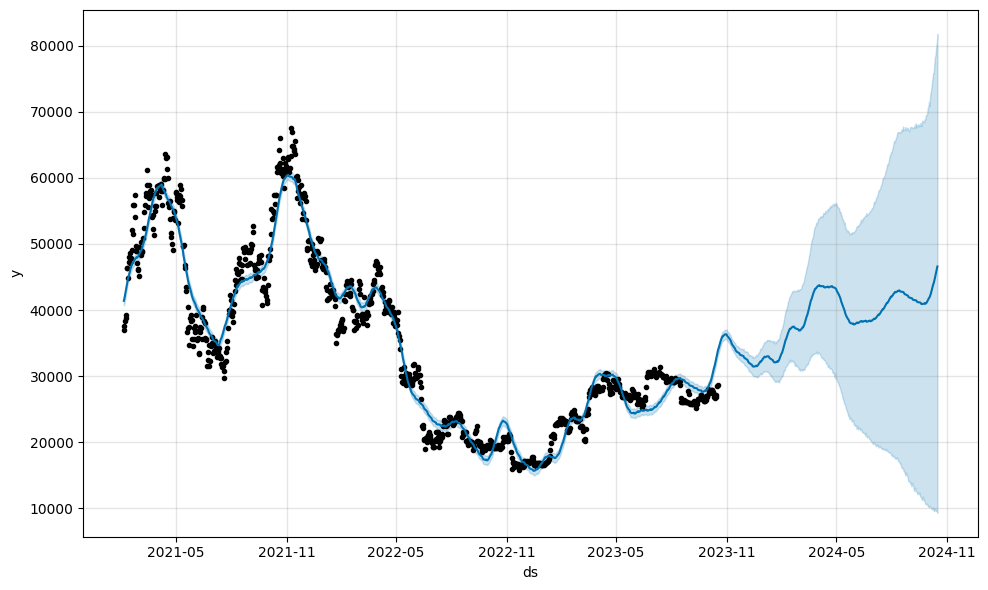

In [74]:
fig1 = model.plot(main_forecast)

 Break down the forecast into its various components

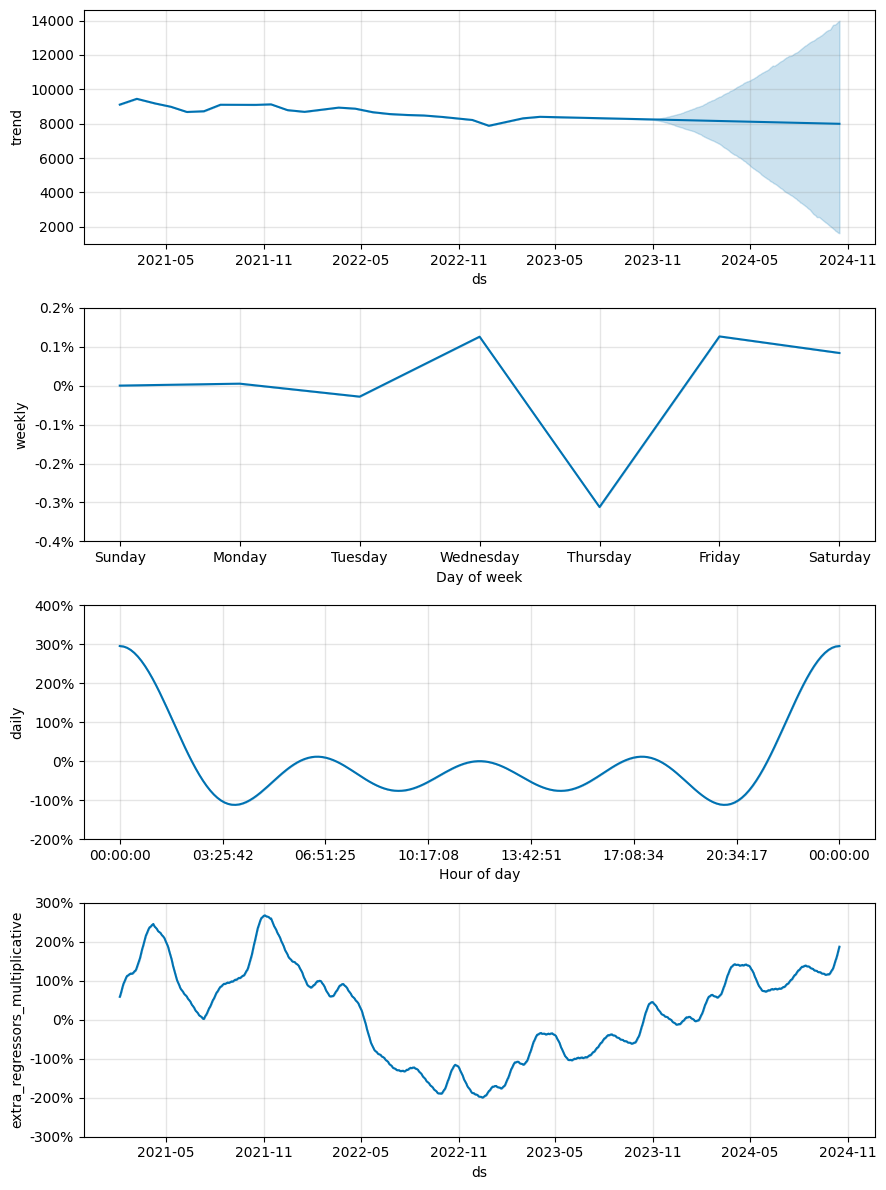

In [75]:
fig2 = model.plot_components(main_forecast)

Setup & Perform Cross-Validation

In [76]:
from prophet.diagnostics import cross_validation

# Here's an example setup:
# Initial training period = 730 days (2 years)
# Horizon = 90 days
# Period = 30 days (i.e., make a forecast every 30 days)

df_cv = cross_validation(model, initial='730 days', period='30 days', horizon='90 days')

  0%|          | 0/6 [00:00<?, ?it/s]06:30:14 - cmdstanpy - INFO - Chain [1] start processing
06:30:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.02s/it]06:30:15 - cmdstanpy - INFO - Chain [1] start processing
06:30:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.23s/it]06:30:17 - cmdstanpy - INFO - Chain [1] start processing
06:30:18 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.25s/it]06:30:18 - cmdstanpy - INFO - Chain [1] start processing
06:30:18 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.05s/it]06:30:19 - cmdstanpy - INFO - Chain [1] start processing
06:30:19 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:00,  1.04it/s]06:30:19 - cmdstanpy - INFO - Chain [1] start processing
06:30:20 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Compute Performance Metrics

In [77]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
print(df_p.head())

  horizon            mse        rmse         mae      mape     mdape  \
0  9 days  716912.802340  846.707035  702.179144  0.025708  0.024141   
1 10 days  730979.967410  854.973665  716.727937  0.026157  0.023738   
2 11 days  716312.677520  846.352573  707.742799  0.025793  0.023163   
3 12 days  690275.542398  830.828227  695.807582  0.025338  0.023163   
4 13 days  665063.699837  815.514377  682.153531  0.024838  0.022707   

      smape  coverage  
0  0.025796  0.500000  
1  0.026229  0.518519  
2  0.025842  0.537037  
3  0.025388  0.537037  
4  0.024875  0.555556  


Visualizing Performance

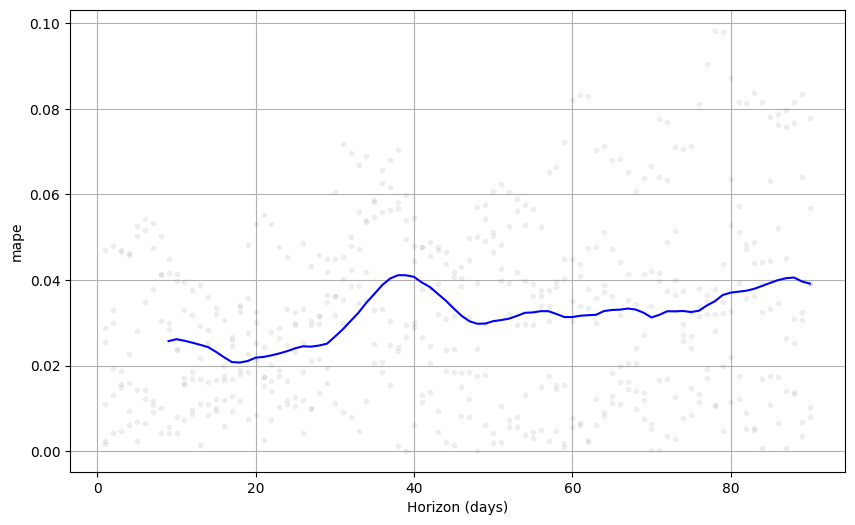

In [78]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mape')

Compute the percentage accuracy from MAPE

In [79]:
# Assuming df_p is the result from the performance_metrics function
mape = df_p['mape'].mean()
accuracy = 100 - (mape * 100)
print(f"Forecast Accuracy: {accuracy:.2f}%")

Forecast Accuracy: 96.84%
